In [1]:
# The operation probability is dependent on the operation history
# Add cosh and sinh as basic functions.
# Multithread operations

from sympy import *
import random
import numpy as np
from scipy.optimize import curve_fit
from copy import deepcopy
from math import isnan
from operator import attrgetter
import matplotlib.pyplot as plt
from os import path
from time import time
import threading
import queue
import csv

In [2]:
def NLOptimizer(expr, inputs, coeffs, inputData, outputData, p0):
  #Get optimized coefficients for giving inputData and outputData
  #Based on gradient. Make sure the expression is derivable
  g = lambdify([*inputs, *coeffs], expr, modules=["numpy"])
  def sympyFunc(inputs, *coeffs):
    return g(*inputs, *coeffs)
  
  try:
    OPT, Var = curve_fit(sympyFunc, inputData, outputData, p0)
    # OPT, Var = curve_fit(sympyFunc, inputData, outputData)
  except:
    print("Unable to find optimal values...")
    OPT = []
  return OPT


c, T = symbols('c T') #Parameters
t = symbols('t') #Inputs
factors = [c, T]
inputs = [t]
sym_weights = (0.4,0.8,1.0) #Decide whether a symbol is a parameter, input or factor. 

operations = [Add, "Sub", Pow, Mul, "Div", sin, cos, exp, sinh, cosh, Symbol]
op_weights = [0.5, 0.4, 0.1, 0.3, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]



class BinExprTreeNode:
  #Definition of the Expression Tree Node
  def __init__(self):
    self.mode = None 
    #0 for coefficient; 1 for inputs or parameters; 2 for 1 argument; 3 for 2 argument;
    self.val = "Ready"
    self.left = None
    self.right = None

class BinExprTree:
  #Definition of the Expression Tree
  def __init__(self):
    self.symplifed = False
    self.root = BinExprTreeNode()
    self.symbols = []
    self.depth = 0
    self.maxDepth = 3
    self.expression = None
    self.abstractExpression = None
    self.formExpression = None
    self.loss = float('inf')
    self.weightedLoss = float('inf')
    self.numOfNodes = 0
    self.coeffPenalty = 0.05


  def randomRespawn(self):
    self.root = self.createRandomNode(0, op_weights[:])

  def createRandomNode(self, depth, practical_weights = op_weights):
    if depth > self.maxDepth:
      return self.createSymbolNode()
    # randomly create a node 
    node = BinExprTreeNode()
    self.depth = max(depth, self.depth)
    op = random.choices(operations, weights=practical_weights)[0]
    node.val = op
    # print("Operation Chosen:", op)
    if op in [Add, Mul,Pow]:
      node.mode = 3
      if op == Pow:
        practical_weights[2] = 0.0
      node.left = self.createRandomNode (depth + 1, practical_weights[:])
      node.right = self.createRandomNode(depth + 1, practical_weights[:])

    elif op == "Sub": # If the operation is substraction
      node.val = Add
      node.mode = 3
      node.left = self.createRandomNode (depth + 1, practical_weights[:])
      node.right = BinExprTreeNode()
      node.right.val = Mul
      node.right.mode = 3
      node.right.left = BinExprTreeNode()
      node.right.left.val = -1
      node.right.left.mode = 0
      node.right.right = self.createRandomNode(depth + 2, practical_weights[:])

    elif op == "Div": #If the operation is division
      node.val = Mul
      node.mode = 3
      node.left = self.createRandomNode (depth + 1, practical_weights[:])
      node.right = BinExprTreeNode()
      node.right.mode = 3
      node.right.val = Pow
      node.right.right = BinExprTreeNode()
      node.right.right.val = -1
      node.right.right.mode = 0
      node.right.left = self.createRandomNode(depth + 2, practical_weights[:])

    elif op in [sin,cos,exp, sinh, cosh]:
      node.mode = 2
      if op == sin or op == cos:
        practical_weights[5] = 0
        practical_weights[6] = 0
      
      elif op == exp:
        practical_weights[7] = 0
      else:
        practical_weights[8] = 0
        practical_weights[9] = 0
      node.left = self.createRandomNode(depth + 1, practical_weights[:])
    
    else:
      node = self.createSymbolNode()

    # print(practical_weights)
    return node

  def createSymbolNode(self):
    #Create a node that is a symbol
    node = BinExprTreeNode()
    trailNum = random.uniform(0, 1)
    if trailNum < sym_weights[0]:
      node.mode = 1
      node.val = random.choice(factors)
    elif trailNum < sym_weights[1]:
      node.mode = 1
      node.val = random.choice(inputs)
    else:
      node.mode = 0
      coeff = Float(random.uniform(0,1), 3)
      node.val = coeff
    return node  
    
  def mutate(self):
    if self.numOfNodes == 0:
      print("There is not any nodes. Make sure you have simplifed the tree")
      return

    # target = random.randint(1,max(self.numOfNodes, 2**self.maxDepth))
    target = random.randint(1, self.numOfNodes)
    targetParent = None
    targetLeftOrRight = 0
    targetDepth = 0
    cur = 0

    # print("Mutate from the ", target, " Node")
    def dfs(parent, leftOrRight, node, depth): # Take parent, left child or right child, node and depth as argument.
      # To find the target node and mutate it
      # return parent node,  leftOrRight and depth
      nonlocal cur
      nonlocal target
      nonlocal targetParent
      nonlocal targetLeftOrRight
      nonlocal targetDepth


      if node == None:
        return
      cur += 1

      if cur == target:
        targetParent = parent
        targetLeftOrRight = leftOrRight
        targetDepth = depth
        return
      if cur > target:
        return
  
      dfs(node, -1, node.left, depth + 1)
      dfs(node, 1, node.right, depth + 1)
    dfs (None, None, self.root, 0)

    # if targetLeftOrRight == -1:
    #   print("Node to change is the left node, it is: ", targetParent.left.val)
    # elif targetLeftOrRight == 1:
    #   print("Node to change is the right node, it is: ", targetParent.right.val)
    if targetParent ==  None:
      self.root = self.createRandomNode(0)
    else:
      if targetLeftOrRight == -1:
        targetParent.left = self.createRandomNode(targetDepth)
      elif targetLeftOrRight == 1:
        targetParent.right = self.createRandomNode(targetDepth)

    self.refreshExpression()
    self.sympifyTree()
    # print("Finished mutation. Expression now is: ", self.expression)
    
      

  def refreshExpression(self):
    #Get full sympy expression of the Tree
    def getExpression(node):
    #From a node, generates the sympy expression for it.
        if node.mode == 0 or node.mode == 1:
          return node.val
        elif node.mode == 2:
          if node.val == sin:
            return sin(getExpression(node.left))
          elif node.val == cos:
            return cos(getExpression(node.left))
          elif node.val == exp:
            return exp(getExpression(node.left))
          elif node.val == sinh:
            return sinh(getExpression(node.left))
          else:
            return cosh(getExpression(node.left))
        else:
          if node.val == Add:
            return getExpression(node.left) + getExpression(node.right)
          elif node.val == Mul:
            return getExpression(node.left) * getExpression(node.right)
          else:
            return getExpression(node.left) ** getExpression(node.right) 
    self.expression = getExpression(self.root)

  def sympifyTree(self):
    self.numOfNodes = 0
    def reconstruct(expr_list, preknown_op=None): 
      '''
      Reconstruct tree from self.expression once refresh Expression is run. 
      This will give the simplest structure of the Tree 
      '''
      # print("Considering:", expr_list)
      # self.expression is symplifed, convert expression to a Tree
      node = BinExprTreeNode()
      if not preknown_op:
        # it also means only one expression is input
        expr = expr_list[0]
        if not expr.args:
          if expr in factors or expr in inputs:
            node.mode = 1
          else:
            node.mode  = 0
          node.val = expr
          # print(node.val)
        elif expr.func in [sin, cos, exp, sinh, cosh]:
          node.mode = 2
          node.val = expr.func
          node.left = reconstruct(list(expr.args), None)
        else:
          # print("What? ", expr_list)
          node.mode = 3
          node.val = expr.func
          if len(expr.args) == 2:
            node.left = reconstruct([expr.args[0]], None)
            node.right = reconstruct([expr.args[1]], None)
          else:
            node.left = reconstruct([expr.args[0]], None)
            node.right = reconstruct(list(expr.args[1:]), expr.func)
      else:
        # The preknown_op can only be Add, Mul, Pow
        if len(expr_list) < 2:
          print("Program Bug")
        elif len(expr_list) == 2:
          node.val = preknown_op
          node.left = reconstruct([expr_list[0]], None)
          node.right = reconstruct([expr_list[1]], None)
          node.mode = 3
        else:
          # print("Here")
          node.val = preknown_op
          node.left = reconstruct([expr_list[0]], None)
          node.right = reconstruct(expr_list[1:], preknown_op)
          node.mode = 3
      self.numOfNodes += 1
      # print(self.numOfNodes)
      return node
    self.root = reconstruct([self.expression], None)
    self.symplifed = True

  def getAbstractExpression(self):
    '''
    Get expression where numbers are replaced by symbols
    '''
    if not self.symplifed:
      print("Symplify the Tree first")
      return -1
    self.symbols = []
    def getAExpression(node):
      if node.mode == 0:
        try:
          flag = float(node.val).is_integer()
        except:
          flag = False
        if flag:
          return node.val
        else:
          symName = 'a' + str(len(self.symbols))
          self.symbols.append(symbols(symName))
          return self.symbols[-1]
      elif node.mode == 1:
        return node.val
      elif node.mode == 2:
        if node.val == sin:
          return sin(getAExpression(node.left))
        elif node.val == cos:
          return cos(getAExpression(node.left))
        elif node.val == exp:
          return exp(getAExpression(node.left))
        elif node.val == sinh:
          return sinh(getAExpression(node.left))
        else:
          return cosh(getAExpression(node.left))
      else:
        if node.val == Add:
          return getAExpression(node.left) + getAExpression(node.right)
        elif node.val == Mul:
          return getAExpression(node.left) * getAExpression(node.right)
        else:
          return getAExpression(node.left) ** getAExpression(node.right)
    self.abstractExpression = getAExpression(self.root)
  
  def getNonCoeffExpression(self):
    '''
    Get an expression with no coefficients. Coefficient is seen as one.
    '''
    if not self.symplifed:
      print("Symplify the Tree first")
      return -1
    def getOneExpression(node):
      if node.mode == 0:
        return Integer(1)
      elif node.mode == 1:
        return node.val
      elif node.mode == 2:
        if node.val == sin:
          return sin(getOneExpression(node.left))
        elif node.val == cos:
          return cos(getOneExpression(node.left))
        else:
          return exp(getOneExpression(node.left))
      else:
        if node.val == Add:
          return getOneExpression(node.left) + getOneExpression(node.right)
        elif node.val == Mul:
          return getOneExpression(node.left) * getOneExpression(node.right)
        else:
          return getOneExpression(node.left) ** getOneExpression(node.right)
    self.formExpression = getOneExpression(self.root)

  def subsitute(self, coeffs):
    '''
    susitute coefficient symbols by coeffs values. Saved the new expression as the 
    expression of the tree
    '''
    match = dict(zip(self.symbols, coeffs))
    # print(match)
    self.expression = self.abstractExpression.subs(match)


  def optimize(self, inputData, targetData):
    '''
    optimize the expression by fitting the coefficients
    '''
    if len(self.symbols) == 0:
      print("No parameters to fit")
      return
    
    initialGuess = np.random.rand(1,len(self.symbols))
    coeffValues = NLOptimizer(self.abstractExpression, inputs+factors, self.symbols
                              ,inputData, targetData, initialGuess)
    # print(coeffValues)
    if len(coeffValues) != 0:
      self.subsitute(coeffValues)
    
    return     
  
  def calculateLoss(self, inputData, targetData):
    try:
      f = lambdify([inputs + factors], self.expression, modules = ["numpy"])
      if len(inputData) == 0:
        print("No data fed")
        return float ('inf')
      if len(inputData[0]) != len(targetData):
        print("input number and target number not match")
        return float ('inf')
      dataToFeed = inputData
      
      self.loss = sum((f(dataToFeed) - targetData)**2)/inputData.shape[0]
      if isnan(self.loss):
        self.loss = float('inf')
      elif not np.isreal(self.loss):
        self.loss = float('inf')
    except:
      print("Loss calculation failed")
      self.loss = float('inf')

    self.weightedLoss = self.loss + len(self.symbols) * self.coeffPenalty

  def __repr__ (self):
    #Print out the sympy expression of the expression Tree
    return self.expression


In [3]:
# Testing
testTree = BinExprTree()
testTree.randomRespawn()
testTree.refreshExpression()
testTree.expression


-cosh(T + c) + 1 + (c + 0.514)/c

In [4]:
# Testing
testTree.sympifyTree()
testTree.expression

-cosh(T + c) + 1 + (c + 0.514)/c

In [5]:
# Testing
testTree.getAbstractExpression()
testTree.abstractExpression

-cosh(T + c) + 1 + (a0 + c)/c

In [ ]:
# Testing
print(testTree.numOfNodes)
testTree.mutate()
testTree.expression

12


cosh(exp(2.29*t)*sinh(-T + t))

In [6]:
# Testing
testTree.getAbstractExpression()
testTree.abstractExpression

-cosh(T + c) + 1 + (a0 + c)/c

In [ ]:
# '''
# Create some data for Test
# '''

# tData = np.linspace(0.1,1.1,101)
# cData = np.linspace(0.1,3.1,101)
# TData = np.linspace(1.,2., 101)


# print(inputData)
# print(inputData.shape)
# hData = 3*tData + np.sin(TData) + 5*cData + 6*cData*TData
# hData

In [7]:
#Load simulation Data MSD vs Time
tData = []
TData = []
cData = []
msdData = []
concentrations = [20, 36, 50, 64, 80]
Temperatures = [400, 500, 600, 700, 800, 900, 1000]

def loadData(c): # Enter concentration 
  prefix = "drive/MyDrive/MSD_vs_Time/" + "Cu" + str(c) + "Zr" + str(100 - c) + '/'
  c /= 100

  for T in Temperatures:
    fileName = prefix + str(T) +'K_all_msd.txt' 
    T /= 100
    if not path.isfile(fileName):
      print(fileName + ' does not exist')
      continue

    with open(fileName) as f:
      print("reading" + fileName)
      interval = 50
      f.readline()
      i = 0
      while(True):
        if i > 2000:
          interval = 500
        line = f.readline()
        # print(line)
        if (i%interval == 0):
          try:
            t, _, _, _, msd = line.split(" ")
          except:
            break
          t = float(t)*0.002
          msd = float(msd)
          tData.append(t)
          msdData.append(msd)
          TData.append(T)
          cData.append(c)

        i += 1        
    f.close()

drive/MyDrive/MSD_vs_Time/Cu20Zr80/400K_all_msd.txt does not exist
readingdrive/MyDrive/MSD_vs_Time/Cu20Zr80/500K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu20Zr80/600K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu20Zr80/700K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu20Zr80/800K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu20Zr80/900K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu20Zr80/1000K_all_msd.txt
drive/MyDrive/MSD_vs_Time/Cu36Zr64/400K_all_msd.txt does not exist
readingdrive/MyDrive/MSD_vs_Time/Cu36Zr64/500K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu36Zr64/600K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu36Zr64/700K_all_msd.txt
drive/MyDrive/MSD_vs_Time/Cu36Zr64/800K_all_msd.txt does not exist
readingdrive/MyDrive/MSD_vs_Time/Cu36Zr64/900K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu36Zr64/1000K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu50Zr50/400K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Time/Cu50Zr50/500K_all_msd.txt
readingdrive/MyDrive/MSD_vs_Ti

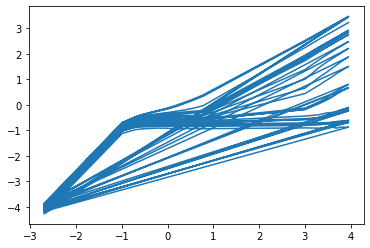

In [8]:
#Load simulation Data MSD vs Time
for concentration in concentrations:
  loadData(concentration)

print(len(tData))
tData = np.array(tData)
cData = np.array(cData)
TData = np.array(TData)
msdData = np.array(msdData)
tData = np.log10(tData)
msdData = np.log10(msdData)

plt.plot(tData, msdData)


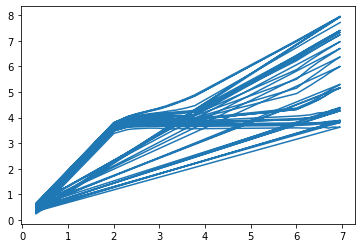

In [9]:
#Modify simulation Data MSD vs Time
tData = tData + 3
msdData = msdData + 4.5

plt.plot(tData, msdData)
inputData = np.array([tData, cData, TData])

180


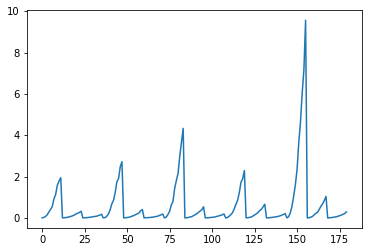

In [10]:
tData = []
TData = []
cData = []
msdData = []

with open("drive/MyDrive/msd-GP.csv", 'r') as file:
  reader = csv.reader(file)
  next(reader)
  for row in reader:
    tData.append(float(row[6])) # t is for temperature
    TData.append(float(row[1])) # T is for composition
    cData.append(float(row[3])) # c is for log(QuenchRate)
    msdData.append(float(row[8])) # msd is for scaled msd

tData = np.array(tData)
cData = np.array(cData)
TData = np.array(TData)
msdData = np.array(msdData)

# msdData = np.log10(msdData)
msdData = msdData/2
tData = tData/100
cData = cData-9
plt.plot(msdData)
print(len(msdData))
inputData = np.array([tData, cData, TData])

In [ ]:
# Testing
testTree.getAbstractExpression()
testTree.optimize(inputData, msdData)

<string>:2: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [11]:
# Testing
tree1 = BinExprTree()
tree1.randomRespawn()
tree1.refreshExpression()
print(tree1.expression)
tree1.sympifyTree()
tree1.getAbstractExpression()
print(tree1.symbols)
print(tree1.abstractExpression)
tree1.getNonCoeffExpression()
tree1.formExpression

2*T + T/sin(T) - 0.986 + exp(c)/T
[a0]
2*T + T/sin(T) + a0 + exp(c)/T


T*exp(c) + T*sin(T) + T + 1

In [14]:
# Testing
tree1.expression
# tree1.calculateLoss(inputData, msdData)
# tree1.loss

2*T + T/sin(T) - 0.986 + exp(c)/T

In [15]:
# Testing
tree1.optimize(inputData, msdData)
tree1.expression

2*T + T/sin(T) - 26.8195471298944 + exp(c)/T

In [16]:
# Testing
tree1.calculateLoss(inputData, msdData)
tree1.loss

37834.204912236346

In [ ]:
# Testing
for i in range(100):
  curTree = BinExprTree()
  curTree.randomRespawn()
  curTree.refreshExpression()
  curTree.sympifyTree()
  curTree.getAbstractExpression()
  print(curTree.abstractExpression)
  curTree.optimize(inputData, msdData)
  curTree.calculateLoss(inputData, msdData)
  # print("expression", i, "is :",curTree.expression)
  print("expression", i, "loss is: ", curTree.loss)



In [19]:
class GPForest:
  def __init__(self, populationSize = 100, maxGenerations = 50, crossoverRate = 0.8,
               mutationRate = 0.3, eliteNum = 5):
    self.populationSize = populationSize
    self.maxGenerations = maxGenerations
    self.currentGeneration = []
    self.crossoverRate = crossoverRate
    self.mutationRate = mutationRate
    self.eliteNum = eliteNum
    self.generationNum = 0
    self.formLib = set()

  def createAGeneration(self):
    while(len(self.currentGeneration) < self.populationSize):
      curTree = BinExprTree()
      curTree.randomRespawn()
      curTree.refreshExpression()
      curTree.sympifyTree()
      curTree.getAbstractExpression()
      if curTree.abstractExpression in self.formLib:
        print("Expression exists. Skip...")
        continue
      else:
        self.formLib.add(curTree.abstractExpression)
        curTree.optimize(inputData, msdData)
        curTree.calculateLoss(inputData, msdData)
        self.currentGeneration.append(deepcopy(curTree))

    self.currentGeneration.sort(key=attrgetter('weightedLoss'))

  def printCurrGeneration(self):
    members = []
    for tree in self.currentGeneration:
      members.append((tree.weightedLoss, tree.loss, tree.abstractExpression))
    for member in members:
      print("Expression is: ", member[2], "weighted loss is: ", member[0], "loss is: ", member[1])

  def printBestCandidates(self, n):
    members = []
    for i in range(n):
      print("Expression is: ", self.currentGeneration[i].abstractExpression,
            "loss is ", self.currentGeneration[i].loss, "weighted loss is ", self.currentGeneration[i].weightedLoss)

  def crossover(self, Tree1, Tree2):
    tree1 = deepcopy(Tree1)
    tree2 = deepcopy(Tree2)


    target1 = random.randint(1,tree1.numOfNodes)
    target2 = random.randint(1,tree2.numOfNodes)
    # print(target1, target2,"out of ",tree1.numOfNodes, tree2.numOfNodes)

    targetParent1 = None
    targetParent2 = None
    targetLeftOrRight1 = 0
    targetLeftOrRight2 = 0

    def dfsTree1(parent, leftOrRight, node): # Take parent of the node, if the node is the left child or the right child, node itself.
      nonlocal cur
      nonlocal targetParent1
      nonlocal targetLeftOrRight1
      nonlocal target1


      if node == None:
        return 
      
      cur += 1
      if cur == target1:
        targetParent1 = parent
        targetLeftOrRight1 = leftOrRight
        return 
      if cur > target1:
        return
      dfsTree1(node, -1, node.left)
      dfsTree1(node, 1, node.right)

    def dfsTree2(parent, leftOrRight, node): # Take parent of the node, if the node is the left child or the right child, node itself.
      nonlocal cur
      nonlocal targetParent2
      nonlocal targetLeftOrRight2
      nonlocal target2

      if node == None:
        return
      cur += 1
      if cur == target2:
        targetParent2 = parent
        targetLeftOrRight2 = leftOrRight
        return 
      if cur > target2:
        return
      dfsTree2(node, -1, node.left)
      dfsTree2(node, 1, node.right)

    cur = 0
    dfsTree1(None, 0, tree1.root)

    cur = 0
    dfsTree2(None, 0, tree2.root)
    # print(targetParent1, targetParent2)
    # print(targetLeftOrRight1, targetLeftOrRight2)


    if targetLeftOrRight1 == -1: # It's left
      swap = deepcopy(targetParent1.left)
      if targetLeftOrRight2 == -1:
        targetParent1.left = deepcopy(targetParent2.left)
        targetParent2.left = swap
      elif targetLeftOrRight2 == 1:
        targetParent1.left = deepcopy(targetParent2.right)
        targetParent2.right = swap

    elif targetLeftOrRight1 == 1:
      swap = deepcopy(targetParent1.right)
      if targetLeftOrRight2 == -1:
        targetParent1.right = deepcopy(targetParent2.left)
        targetParent2.left = swap
      elif targetLeftOrRight2 == 1:
        targetParent1.right = deepcopy(targetParent2.right)
        targetParent2.right = swap

    tree1.refreshExpression()
    tree2.refreshExpression()
    tree1.sympifyTree()
    tree2.sympifyTree()

    return tree1, tree2

  def updateGeneration(self):
    print("Updating current generation...")
    newGeneration = self.currentGeneration[:self.eliteNum]
    self.formLib = set(newGeneration)

    # parentProbability = list(range(1,len(self.currentGeneration)+1))[::-1]
    parentProbability = [1] * len(self.currentGeneration)
    indexList = list(range(len(self.currentGeneration)))
    while(len(newGeneration) < self.populationSize):
      print(len(newGeneration))
      child_1, child_2 = random.choices(indexList,weights = parentProbability, k = 2)
      child_1 = deepcopy(self.currentGeneration[child_1])
      child_2 = deepcopy(self.currentGeneration[child_2])

      can_crossover = random.random() < self.crossoverRate
      can_mutate = random.random() < self.mutationRate

      if can_crossover:
        child_1, child_2 = self.crossover(child_1, child_2)
        child_1.refreshExpression()
        child_1.sympifyTree()

        child_2.refreshExpression()
        child_2.sympifyTree()

      if can_mutate:
        child_1.mutate()
        child_2.mutate()

        child_1.refreshExpression()
        child_1.sympifyTree()

        child_2.refreshExpression()
        child_2.sympifyTree()

      child_1.getAbstractExpression()
      if (child_1.abstractExpression not in self.formLib):
        child_1.optimize(inputData, msdData)
        child_1.calculateLoss(inputData, msdData)
        newGeneration.append(deepcopy(child_1))
        self.formLib.add(child_1.abstractExpression)

      child_2.getAbstractExpression()
      if (child_2.abstractExpression not in self.formLib):
        child_2.optimize(inputData, msdData)
        child_2.calculateLoss(inputData, msdData)
        newGeneration.append(deepcopy(child_2))
        self.formLib.add(child_2.abstractExpression)
    
    self.currentGeneration = newGeneration[:self.populationSize]
    self.currentGeneration.sort(key=attrgetter('weightedLoss'))

  def multiThreadUpdate(self):
    newGeneration = self.currentGeneration[:self.eliteNum]
    self.formLib = set(newGeneration)
    # parentProbability = list(range(1,len(self.currentGeneration)+1))[::-1]
    parentProbability = [1] * len(self.currentGeneration)
    indexList = list(range(len(self.currentGeneration)))

    q = queue.Queue()
    q.queue = queue.deque(newGeneration)
    portion = self.populationSize // 4
    lastPortion = self.populationSize - portion*3

    def getTwoChildren(totalNum):
      i = 0
      while(i < totalNum):
        child_1, child_2 = random.choices(indexList,weights = parentProbability, k = 2)
        child_1 = deepcopy(self.currentGeneration[child_1])
        child_2 = deepcopy(self.currentGeneration[child_2])

        can_crossover = random.random() < self.crossoverRate
        can_mutate = random.random() < self.mutationRate

        if can_crossover:
          child_1, child_2 = self.crossover(child_1, child_2)
          child_1.refreshExpression()
          child_1.sympifyTree()

          child_2.refreshExpression()
          child_2.sympifyTree()

        if can_mutate:
          child_1.mutate()
          child_2.mutate()

          child_1.refreshExpression()
          child_1.sympifyTree()

          child_2.refreshExpression()
          child_2.sympifyTree()
      
        child_1.getAbstractExpression()
        if (child_1.abstractExpression not in self.formLib):
          child_1.optimize(inputData, msdData)
          child_1.calculateLoss(inputData, msdData)
          q.put(deepcopy(child_1))
          i += 1
          self.formLib.add(child_1.abstractExpression)

        child_2.getAbstractExpression()
        if (child_2.abstractExpression not in self.formLib):
          child_2.optimize(inputData, msdData)
          child_2.calculateLoss(inputData, msdData)
          q.put(deepcopy(child_2))
          i += 1
          self.formLib.add(child_2.abstractExpression)

    t1 = threading.Thread(target = getTwoChildren,args = (portion,))
    t2 = threading.Thread(target = getTwoChildren,args = (portion,))
    t3 = threading.Thread(target = getTwoChildren,args = (portion,))
    t4 = threading.Thread(target = getTwoChildren,args = (lastPortion,))

    t1.start()
    t2.start()
    t3.start()
    t4.start()
    
    q.join()

    t1.join()
    t2.join()
    t3.join()
    t4.join()

    self.currentGeneration = list(q.queue)[:self.populationSize]
    self.currentGeneration.sort(key=attrgetter('weightedLoss'))

  def run(self):
    i = 0
    t1 = time()
    with open('output.log','w') as f:
      while(i<self.maxGenerations):
        f.write("%s %d\n" % ("Generation ", i))
        self.updateGeneration()
        # self.multiThreadUpdate()
        print("Generation ", i)
        self.printBestCandidates(5)
        i += 1
        f.write("Best 5 candidates: \n")
        for j in range(5):
          f.write("%s %s %s %f\n\n" % ("Expression is: ", self.currentGeneration[j].abstractExpression,
              "loss is ", self.currentGeneration[j].loss))
      
      f.write("Final Generation: \n")
      for j in range(len(self.currentGeneration)):
        f.write("%s %s %s %f\n\n" % ("Expression is: ", self.currentGeneration[j].abstractExpression,
              "loss is ", self.currentGeneration[j].loss))
    
    t2 = time()
    print("average time: ", (t2-t1)/i, " per generation")
    return

  def multiThreadRun(self):
    i = 0
    t1 = time()
    with open('output.log','w') as f:
      while(i<self.maxGenerations):
        f.write("%s %d\n" % ("Generation ", i))
        self.multiThreadUpdate()
        print("Generation ", i)
        self.printBestCandidates(5)
        i += 1
        f.write("Best 5 candidates: \n")
        for j in range(5):
          f.write("%s %s %s %f\n\n" % ("Expression is: ", self.currentGeneration[j].abstractExpression,
              "loss is ", self.currentGeneration[j].loss))
      
      f.write("Final Generation: \n")
      for j in range(len(self.currentGeneration)):
        f.write("%s %s %s %f\n\n" % ("Expression is: ", self.currentGeneration[j].abstractExpression,
              "loss is ", self.currentGeneration[j].loss))
    
    t2 = time()
    print("average time: ", (t2-t1)/i, " per generation")
    return

    
  

In [ ]:
# Some test
a = [1,2,3,4,float('nan'),4,1,2,float('inf'),32,12]
a.sort(key=lambda x: float('inf') if isnan(x) else x)
a

[1, 1, 2, 2, 3, 4, 4, 12, 32, nan, inf]

In [20]:
# Testing for createAGeneration method
Forest1 = GPForest()
Forest1.createAGeneration()


No parameters to fit
No parameters to fit
No parameters to fit


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:766: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: overflow encountered in square
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in sinh
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
<string>:3: RuntimeWarning: overflow encountered in sinh
<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit


<string>:3: RuntimeWarning: overflow encountered in sinh


No parameters to fit
Expression exists. Skip...
No parameters to fit
No parameters to fit
Expression exists. Skip...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
No parameters to fit
Expression exists. Skip...
No parameters to fit
Expression exists. Skip...
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
Unable to find optimal values...
No parameters to fit
Expression exists. Skip...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: overflow encountered in sinh


No parameters to fit
No parameters to fit
Expression exists. Skip...


<string>:3: RuntimeWarning: overflow encountered in sinh
<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


Expression exists. Skip...
No parameters to fit
Expression exists. Skip...
No parameters to fit
No parameters to fit


<string>:3: RuntimeWarning: overflow encountered in cosh
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Expression exists. Skip...
Expression exists. Skip...
No parameters to fit
Expression exists. Skip...
Expression exists. Skip...
Expression exists. Skip...


In [23]:
Forest1.currentGeneration[90].expression


2*T/((0.0513298700137366 - c)*(T - t))

In [ ]:
Forest1.printCurrGeneration()
#hData = 3*tData + np.sin(TData) + 5*xData + 6*yData*zData

In [ ]:
#Testing for crossover method
testTree1 = deepcopy(Forest1.currentGeneration[0])
testTree2 = deepcopy(Forest1.currentGeneration[1])
testTree1.getAbstractExpression()
testTree2.getAbstractExpression()
print(testTree1.abstractExpression)
print(testTree2.abstractExpression)

testTree1, testTree2 = Forest1.crossover(testTree1, testTree2)

testTree1.getAbstractExpression()
testTree2.getAbstractExpression()
print(testTree1.abstractExpression)
print(testTree2.abstractExpression)
testTree1.optimize(inputData, hData)
testTree2.optimize(inputData, hData)

testTree1.calculateLoss(inputData, hData)
testTree2.calculateLoss(inputData, hData)

print("New loss is: ", testTree1.loss, testTree2.loss)


In [ ]:
#Testing for updateGeneration method
Forest1.updateGeneration()
Forest1.printCurrGeneration()

In [24]:
Forest1 = GPForest(populationSize=70, maxGenerations=100)
Forest1.createAGeneration()
# Forest1.multiThreadRun()
Forest1.run()

No parameters to fit
No parameters to fit
No parameters to fit


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
Unable to find optimal values...
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
No parameters to fit
Expression exists. Skip...
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


Expression exists. Skip...
No parameters to fit
No parameters to fit
Updating current generation...
5
No parameters to fit
7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
9
No parameters to fit
No parameters to fit
11
No parameters to fit
13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


15
No parameters to fit
17
18
No parameters to fit
20
22


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
24
26
28


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
30
No parameters to fit
32


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
No parameters to fit
34
No parameters to fit
36


<string>:2: RuntimeWarning: invalid value encountered in power


38
No parameters to fit
40
No parameters to fit
42
No parameters to fit
No parameters to fit
44
No parameters to fit


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


46
No parameters to fit
No parameters to fit
48
No parameters to fit
No parameters to fit
50


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
No parameters to fit
52
No parameters to fit
54
No parameters to fit
56
No parameters to fit
No parameters to fit
58
60
62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


64
No parameters to fit
No parameters to fit
66
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


68
No parameters to fit
Generation  0
Expression is:  a0 + sinh(T*a1 + a2*cos(c)) loss is  63.95138433543698 weighted loss is  64.10138433543698
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Expression is:  -(c - t)/c loss is  68.25502560148486 weighted loss is  68.25502560148486
Expression is:  a0 + a1*sin(a2 + c) loss is  68.6906605136236 weighted loss is  68.8406605136236
Expression is:  T**a1*a0*t loss is  70.67785907727558 weighted loss is  70.77785907727558
Updating current generation...
5
No parameters to fit
No parameters to fit
7
No parameters to fit
9
11
13
No parameters to fit
15
No parameters to fit
No parameters to fit
17
19


<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: overflow encountered in sinh
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:766: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
<string>:3: RuntimeWarning: overflow encountered in sinh
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: overflow encountered in square
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


21
23
No parameters to fit
No parameters to fit
25
No parameters to fit
No parameters to fit
27
No parameters to fit
29


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


33
No parameters to fit
35
No parameters to fit
37
No parameters to fit
39
41


<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
42
No parameters to fit
No parameters to fit
44
No parameters to fit
45
No parameters to fit
No parameters to fit
47


<string>:3: RuntimeWarning: divide by zero encountered in reciprocal
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
49
No parameters to fit
51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
53
55
No parameters to fit
No parameters to fit
57
59


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
61
No parameters to fit
63
No parameters to fit
65
No parameters to fit
No parameters to fit
67
No parameters to fit
No parameters to fit
69
No parameters to fit
Generation  1
Expression is:  a0 + sinh(T*a1 + a2*cos(c)) loss is  63.95138433543698 weighted loss is  64.10138433543698
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Expression is:  -(c - t)/c loss is  68.25502560148486 weighted loss is  68.25502560148486
Expression is:  -(c - t)/c loss is  68.25502560148486 weighted loss is  68.25502560148486
Updating current generation...
5
No parameters to fit
No parameters to fit
7
No parameters to fit
No parameters to fit
9
No parameters to fit
11
No parameters to fit
13
No parameters to fit
No parameters to fit


<string>:3: RuntimeWarning: invalid value encountered in power


15
17


<string>:2: RuntimeWarning: overflow encountered in cosh
<string>:3: RuntimeWarning: overflow encountered in cosh


No parameters to fit
19
21
23

<string>:2: RuntimeWarning: invalid value encountered in power



No parameters to fit
No parameters to fit
25
No parameters to fit
27
No parameters to fit
29
No parameters to fit
31
No parameters to fit
No parameters to fit
33
35
No parameters to fit
No parameters to fit


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


37
No parameters to fit
39
No parameters to fit
41
No parameters to fit
43
No parameters to fit
45


<string>:2: RuntimeWarning: overflow encountered in sinh
<string>:3: RuntimeWarning: overflow encountered in sinh


Unable to find optimal values...
47
No parameters to fit
49
No parameters to fit
51
53
54
56
58


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
60
No parameters to fit
No parameters to fit
62
No parameters to fit
64
66
68
No parameters to fit
Generation  2
Expression is:  a0 + sinh(T*a1 + a2*cos(c)) loss is  63.95138433543698 weighted loss is  64.10138433543698
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Expression is:  -(c - t)/c loss is  68.25502560148486 weighted loss is  68.25502560148486
Expression is:  -(c - t)/c loss is  68.25502560148486 weighted loss is  68.25502560148486
Updating current generation...
5


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


7
No parameters to fit
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11
13


<string>:2: RuntimeWarning: invalid value encountered in power


15
17
19
No parameters to fit
21
No parameters to fit
No parameters to fit
23
No parameters to fit
No parameters to fit
25
No parameters to fit
27


<string>:2: RuntimeWarning: overflow encountered in sinh
<string>:3: RuntimeWarning: overflow encountered in sinh


No parameters to fit
29
No parameters to fit
No parameters to fit
31
33
No parameters to fit
35
No parameters to fit
37
No parameters to fit
39
No parameters to fit
41
43


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


45
No parameters to fit
No parameters to fit
47
49
No parameters to fit
50
No parameters to fit
52
54


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
56
57
No parameters to fit
58
Unable to find optimal values...
59
61
Unable to find optimal values...
63
65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
67
No parameters to fit
69
No parameters to fit
Generation  3
Expression is:  a0 + sinh(T*a1 + a2*cos(c)) loss is  63.95138433543698 weighted loss is  64.10138433543698
Expression is:  (a1 + c)*(t**t + a2/T)/(a0 + c - t) loss is  64.6160174014228 weighted loss is  64.7660174014228
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Updating current generation...
5
7
No parameters to fit
9
No parameters to fit
11
13
15
No parameters to fit
17
19
No parameters to fit
21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
23
No parameters to fit
No parameters to fit
25
26
No parameters to fit
No parameters to fit
28
No parameters to fit
No parameters to fit
30
No parameters to fit
No parameters to fit
32
No parameters to fit
33
No parameters to fit
34
No parameters to fit


<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: overflow encountered in sinh


36
38
No parameters to fit
40
41
43
No parameters to fit
45
47
No parameters to fit
49
No parameters to fit
51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
53
No parameters to fit
55
55
57
No parameters to fit
No parameters to fit
59
60
No parameters to fit
No parameters to fit
62
64
No parameters to fit
66
67
No parameters to fit
No parameters to fit
69
Generation  4
Expression is:  a0 + sinh(T*a1 + a2*cos(c)) loss is  63.95138433543698 weighted loss is  64.10138433543698
Expression is:  a0 + sinh(T*a1 + a2*cos(c)) loss is  63.951384335813856 weighted loss is  64.10138433581386
Expression is:  (a1 + c)*(t**t + a2/T)/(a0 + c - t) loss is  64.6160174014228 weighted loss is  64.7660174014228
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Expression is:  T*t*cos(c) + (T*t + t)/(t + cos(T)) loss is  66.7147134959192 weighted loss is  66.7147134959192
Updating current generation...
5
7
No parameters to fit
9
11
No parameters to fit
13
15
No parameters to fit
17
No parameters to fit
19
21
No parameters to fit
23
No parameters to fit
25
No parameters to fit
27

<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
39
No parameters to fit
No parameters to fit
41


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
43
44
46
No parameters to fit
48
No parameters to fit
No parameters to fit
50
51
No parameters to fit
53


<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
55
No parameters to fit
57
59
61
No parameters to fit
63
65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


67
No parameters to fit
No parameters to fit
69
Generation  5
Expression is:  a0*t*(a1 + c) + t loss is  45.2556721988139 weighted loss is  45.3556721988139
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(T + a5 - t) loss is  50.140099015969064 weighted loss is  50.44009901596906
Expression is:  a0*(c + t)/c + 2*(c + cos(c))*(T + a1 + t)/c loss is  51.348186796274796 weighted loss is  51.4481867962748
Expression is:  T*t*cos(c) + (T**2*c*t + t)/(t + cos(T)) loss is  52.716865214954915 weighted loss is  52.716865214954915
Expression is:  T*a0*t*cos(c)/c + 2*T loss is  53.13491657913989 weighted loss is  53.18491657913989
Updating current generation...
5
No parameters to fit
No parameters to fit
7
No parameters to fit


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


9
No parameters to fit
11
13
No parameters to fit
15


<string>:2: RuntimeWarning: divide by zero encountered in reciprocal
<string>:3: RuntimeWarning: divide by zero encountered in reciprocal
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
17
No parameters to fit
19
No parameters to fit
21
23
No parameters to fit
25
26
28
No parameters to fit
30
No parameters to fit


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


32
No parameters to fit
34
No parameters to fit
36
38
40
42
No parameters to fit
44
46
48
No parameters to fit
No parameters to fit
50
No parameters to fit


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


52
No parameters to fit
54
No parameters to fit
56
58
60
No parameters to fit
62


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


64
No parameters to fit
66
68
No parameters to fit
Generation  6
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150362 weighted loss is  34.73778263150362
Expression is:  a0*t*(a1 + c) + t loss is  45.2556721988139 weighted loss is  45.3556721988139
Expression is:  exp(1/c)*sin(c)*sinh(a0*t) loss is  49.90553461582235 weighted loss is  49.955534615822344
Expression is:  T*a0 + a1*c + t + (T*a3 + a2)*(T + a4 - t) loss is  50.14009899068051 weighted loss is  50.39009899068051
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(T + a5 - t) loss is  50.14009899739606 weighted loss is  50.440098997396056
Updating current generation...
5
No parameters to fit
7


<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


9
11
No parameters to fit
13
15
No parameters to fit
No parameters to fit
17
No parameters to fit
No parameters to fit
19
21
No parameters to fit
No parameters to fit
23


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: invalid value encountered in cos
<string>:2: RuntimeWarning: divide by zero encountered in reciprocal
<string>:3: RuntimeWarning: divide by zero encountered in reciprocal


25
Unable to find optimal values...
27
28
30
32
No parameters to fit
34
36
38
No parameters to fit
40


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


42
No parameters to fit
44
45
No parameters to fit
47
No parameters to fit
49
51
52
54


<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


56
57
No parameters to fit
59
61
No parameters to fit
63


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
65
67
68
No parameters to fit
Generation  7
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411164 weighted loss is  27.445836459411165
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150358 weighted loss is  34.737782631503585
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150362 weighted loss is  34.73778263150362
Expression is:  a0*t*(a1 + c) + t loss is  45.2556721988139 weighted loss is  45.3556721988139
Expression is:  exp(1/c)*sin(c)*sinh(a0*t) loss is  49.90553461582235 weighted loss is  49.955534615822344
Updating current generation...
5


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: divide by zero encountered in reciprocal


7
No parameters to fit
9


<string>:3: RuntimeWarning: divide by zero encountered in reciprocal


No parameters to fit
11
No parameters to fit
12
14


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: divide by zero encountered in reciprocal
<string>:3: RuntimeWarning: divide by zero encountered in reciprocal


16
18
20
Unable to find optimal values...
22
24
26
No parameters to fit
28


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: invalid value encountered in cos


30
No parameters to fit
32
No parameters to fit
34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in reciprocal
<string>:3: RuntimeWarning: divide by zero encountered in reciprocal


36
No parameters to fit
38


<string>:2: RuntimeWarning: divide by zero encountered in reciprocal
<string>:3: RuntimeWarning: divide by zero encountered in reciprocal


40
42
43
45
47
No parameters to fit
49


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
51
No parameters to fit
53
No parameters to fit
55
No parameters to fit
57
57
59
61
63
65


<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
No parameters to fit
67
No parameters to fit
69


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Generation  8
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411164 weighted loss is  27.445836459411165
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150358 weighted loss is  34.737782631503585
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150362 weighted loss is  34.73778263150362
Expression is:  a0*t*(a1 + c) + t loss is  45.2556721988139 weighted loss is  45.3556721988139
Expression is:  exp(1/c)*sin(c)*sinh(a0*t) loss is  49.90553461582235 weighted loss is  49.955534615822344
Updating current generation...
5
7
9
11
12
14
No parameters to fit
16


<string>:2: RuntimeWarning: invalid value encountered in power


18
20
Unable to find optimal values...
No parameters to fit
22
24
Unable to find optimal values...
26


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


27
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
31
No parameters to fit
33
35
No parameters to fit
Unable to find optimal values...
37
No parameters to fit
38


<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


39
41


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


43
No parameters to fit
45
47
49
51
53
53
No parameters to fit
No parameters to fit
55
No parameters to fit
56
57
No parameters to fit
59


<string>:3: RuntimeWarning: overflow encountered in sinh


No parameters to fit
61
61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
63
Unable to find optimal values...
Unable to find optimal values...
65
67
69
No parameters to fit
Generation  9
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411164 weighted loss is  27.445836459411165
Expression is:  T*a1 + a0*t + (T*a3 + a2)*(a4 + t*(a5 + c) - t) loss is  29.26084245149677 weighted loss is  29.56084245149677
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150358 weighted loss is  34.737782631503585
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150362 weighted loss is  34.73778263150362
Expression is:  a0*t*(a1 + c) + t loss is  45.2556721988139 weighted loss is  45.3556721988139
Updating current generation...
5
7
9
11
No parameters to fit
13
No parameters to fit
15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17
19
No parameters to fit
21
No parameters to fit
23
No parameters to fit
25
27
29
30
No parameters to fit
No parameters to fit
32
34


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
36
38
40
42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


44
46
Unable to find optimal values...
48
50


<string>:3: RuntimeWarning: overflow encountered in sinh


No parameters to fit
52
54
56
58
60
62
64
66
Unable to find optimal values...
68
Unable to find optimal values...
Generation  10
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411164 weighted loss is  27.445836459411165
Expression is:  T*t*(a0 + a1/T)*(a2 + cos(c)) loss is  27.422093222891515 weighted loss is  27.572093222891514
Expression is:  T*a1 + a0*t + (T*a3 + a2)*(a4 + t*(a5 + c) - t) loss is  29.26084245149677 weighted loss is  29.56084245149677
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150358 weighted loss is  34.737782631503585
Expression is:  T*(-T + T**t*a1 + a0*t)/c loss is  34.63778263150362 weighted loss is  34.73778263150362
Updating current generation...
5


<string>:3: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
9
No parameters to fit
11
13
15
Unable to find optimal values...
17
No parameters to fit
19
21
No parameters to fit
23
25
No parameters to fit
27
No parameters to fit
29
31


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
33
No parameters to fit
35
37
39
41


<string>:2: RuntimeWarning: invalid value encountered in power


43
No parameters to fit
45
46
48
No parameters to fit
50
52
54
56
58
59
61
63
65
67
69
No parameters to fit
Generation  11
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411164 weighted loss is  27.445836459411165
Expression is:  T*t*(a0 + a1/T)*(a2 + cos(c)) loss is  27.422093222891515 weighted loss is  27.572093222891514
Expression is:  T*a0 + a1*c + (T*a3 + a2)*(a4 + t*(a5 + c) - t) loss is  27.288091439949554 weighted loss is  27.588091439949554
Expression is:  T*a1 + a0*t + (T*a3 + a2)*(a4 + t*(a5 + c) - t) loss is  29.26084245149677 weighted loss is  29.56084245149677
Expression is:  T*(T*cos(t) + T**t*a1 + a0*t)/c loss is  31.780095798284844 weighted loss is  31.880095798284845
Updating current generation...
5
No parameters to fit
7
9


<string>:2: RuntimeWarning: invalid value encountered in power


11
13
15
17
19
No parameters to fit
21
23
25
No parameters to fit
27
29
31
33
35
37
No parameters to fit
39
41
Unable to find optimal values...
42
44
46
No parameters to fit
48
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


50
51
53
55
57
59
61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
63
No parameters to fit
65
67
69
Generation  12
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411164 weighted loss is  27.445836459411165
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411313 weighted loss is  27.445836459411314
Expression is:  T*t*(a0 + a1/T)*(a2 + cos(c)) loss is  27.422093222891515 weighted loss is  27.572093222891514
Expression is:  T*a0 + a1*c + (T*a3 + a2)*(a4 + t*(a5 + c) - t) loss is  27.288091439949554 weighted loss is  27.588091439949554
Expression is:  T*a1 + a0*t + (T*a3 + a2)*(a4 + t*(a5 + c) - t) loss is  29.26084245149677 weighted loss is  29.56084245149677
Updating current generation...
5
7
9


<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
13
15
Unable to find optimal values...
17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


19
21
No parameters to fit
23
25
Unable to find optimal values...
27
29
No parameters to fit
31
No parameters to fit
33
No parameters to fit
No parameters to fit
35
37


<string>:2: RuntimeWarning: invalid value encountered in power


39
41
43


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


45
47
49
51
53
55
57
No parameters to fit
59
61


<string>:2: RuntimeWarning: invalid value encountered in power


63
65
67
69
No parameters to fit
Generation  13
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  (a0 - 3*(T*a2 + a1)*(a3 + t*(a4 + c) - t))*(t + cos(T + a5)) loss is  22.642085631331906 weighted loss is  22.942085631331906
Expression is:  T*t*(a0 + (T + a1)/c)*(a2 + cos(c)) loss is  23.56550491155045 weighted loss is  23.715504911550447
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411164 weighted loss is  27.445836459411165
Expression is:  T*a0 + a1*t + a2*c + (T*a4 + a3)*(a5 + t*(a6 + c) - t) loss is  27.095836459411313 weighted loss is  27.445836459411314
Updating current generation...
5
7
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
11
12
14


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


16
18
20


<string>:2: RuntimeWarning: invalid value encountered in power


22
24
26
28
30
32


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
34
No parameters to fit
36
38
40


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
42
44
46
47
No parameters to fit
49
50
52
No parameters to fit
Unable to find optimal values...
54
56
57
No parameters to fit
58
60
61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
63
No parameters to fit
64
66
68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  14
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + t**(c + t))**(T*(T*a3 + a2)*(-T + a4*t - c)) loss is  19.670988652206994 weighted loss is  19.920988652206994
Expression is:  (a0 - 3*(T*a2 + a1)*(a3 + t*(a4 + c) - t))*(t + cos(T + a5)) loss is  22.642085631331906 weighted loss is  22.942085631331906
Expression is:  (a0 - 3*(T*a2 + a1)*(a3 + t*(a4 + c) - t))*(t + cos(T + a5)) loss is  22.642085645074527 weighted loss is  22.942085645074528
Expression is:  T*t*(a0 + (T + a1)/c)*(a2 + cos(c)) loss is  23.56550491155045 weighted loss is  23.715504911550447
Updating current generation...
5
7
Unable to find optimal values...
9
No parameters to fit
11
13


<string>:3: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power


17
No parameters to fit
19
21
No parameters to fit
23
24
26
No parameters to fit
28
30
32


<string>:2: RuntimeWarning: invalid value encountered in power


34
36
38
No parameters to fit
Unable to find optimal values...


<string>:3: RuntimeWarning: invalid value encountered in power


40


<string>:2: RuntimeWarning: invalid value encountered in power


42
No parameters to fit
44
46
48
50


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


52
54
56
58
No parameters to fit
No parameters to fit
60
61
No parameters to fit
62
64
65


<string>:2: RuntimeWarning: invalid value encountered in power


67
69
Generation  15
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4*t - c)) loss is  15.05529933992112 weighted loss is  15.30529933992112
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.35218012288188 weighted loss is  18.752180122881878
Expression is:  a0*(a1 + t**(c + t))**(T*(T*a3 + a2)*(-T + a4*t - c)) loss is  19.670988652206994 weighted loss is  19.920988652206994
Expression is:  (a0 - 3*(T*a2 + a1)*(a3 + t*(a4 + c) - t))*(t + cos(T + a5)) loss is  22.642085631331906 weighted loss is  22.942085631331906
Updating current generation...
5
7
9


<string>:2: RuntimeWarning: invalid value encountered in power


11
13
Unable to find optimal values...
15
17
19
21


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
23
25
27
29
No parameters to fit
31
No parameters to fit
No parameters to fit
33


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
35
37
38


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
40
42
44
Unable to find optimal values...
46
No parameters to fit
48
50


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


52
54
No parameters to fit
56


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


57
58
60
61
61
63
65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


67
69
Generation  16
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4*t - c)) loss is  15.05529933992112 weighted loss is  15.30529933992112
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.35218012288188 weighted loss is  18.752180122881878
Expression is:  a0*(a1 + t**(c + t))**(T*(T*a3 + a2)*(-T + a4*t - c)) loss is  19.670988652206994 weighted loss is  19.920988652206994
Expression is:  (a0 + t)*(a1 - 3*(T*a3 + a2)/c) loss is  21.408308600079565 weighted loss is  21.608308600079564
Updating current generation...
5
No parameters to fit
7
9
11
13


<string>:2: RuntimeWarning: invalid value encountered in power


15
No parameters to fit
17
19
No parameters to fit
21
23
25
Unable to find optimal values...
27
Unable to find optimal values...
29
31
No parameters to fit
32
34
No parameters to fit
36
38
No parameters to fit
40
41
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power


43
45
47
No parameters to fit
49
51
53
55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
56
58
60
No parameters to fit
62
No parameters to fit
64
66
68
Generation  17
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4*t - c)) loss is  15.05529933992112 weighted loss is  15.30529933992112
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.35218012288188 weighted loss is  18.752180122881878
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.352180123654374 weighted loss is  18.752180123654373
Expression is:  a0*(a1 + t**(c + t))**(T*(T*a3 + a2)*(-T + a4*t - c)) loss is  19.670988652206994 weighted loss is  19.920988652206994
Updating current generation...
5
7
9
11
13
15
17
No parameters to fit
19


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
21
Unable to find optimal values...
23
25
No parameters to fit
27
29
31
33
No parameters to fit
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37
39
No parameters to fit
41
43
Unable to find optimal values...
45
No parameters to fit
No parameters to fit
47
No parameters to fit
49
No parameters to fit
51
53
No parameters to fit
55
57


<string>:2: RuntimeWarning: invalid value encountered in power


59
61
62
No parameters to fit


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


64
66


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
67
69
Generation  18
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4*t - c)) loss is  15.05529933992112 weighted loss is  15.30529933992112
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.35218012288188 weighted loss is  18.752180122881878
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.352180123654374 weighted loss is  18.752180123654373
Updating current generation...
5
7
Unable to find optimal values...
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13
Unable to find optimal values...
15


<string>:2: RuntimeWarning: invalid value encountered in power


17
No parameters to fit
19
Unable to find optimal values...
21
No parameters to fit
23
25
Unable to find optimal values...
27
29
31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


33
Unable to find optimal values...
Unable to find optimal values...
35
37
39
41
43
44
No parameters to fit
Unable to find optimal values...
46


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


48
No parameters to fit
50


<string>:2: RuntimeWarning: invalid value encountered in power


52
54
56
58
No parameters to fit
59
60


<string>:2: RuntimeWarning: overflow encountered in power


62
64
65
No parameters to fit
67


<string>:2: RuntimeWarning: overflow encountered in power


68
Generation  19
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4*t - c)) loss is  15.05529933992112 weighted loss is  15.30529933992112
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.35218012288188 weighted loss is  18.752180122881878
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.352180123654374 weighted loss is  18.752180123654373
Updating current generation...
5
7
9
11
13
No parameters to fit
15
No parameters to fit
17
19
21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
Unable to find optimal values...
25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
Unable to find optimal values...


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27
No parameters to fit
29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


31
33
No parameters to fit
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


37
39


<string>:2: RuntimeWarning: invalid value encountered in power


41
43
45
47
49
No parameters to fit
51


<string>:2: RuntimeWarning: invalid value encountered in power


53
55
57
Unable to find optimal values...
59


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
61


<string>:2: RuntimeWarning: invalid value encountered in power


63
65
67
69
Generation  20
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4*t - c)) loss is  15.05529933992112 weighted loss is  15.30529933992112
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.35218012288188 weighted loss is  18.752180122881878
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.352180123654374 weighted loss is  18.752180123654373
Updating current generation...
5
Unable to find optimal values...
Unable to find optimal values...
7


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
9


<string>:3: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power


13
15
16
18
No parameters to fit
20
22
No parameters to fit
24
No parameters to fit
26


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
28
30
32


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


Unable to find optimal values...
34
No parameters to fit
36
38
40
42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
43
45
45
47
48
No parameters to fit
50


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
52
54
56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


58
59
60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


62
63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


67
69
Generation  21
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + c**(c + t))**(-18*T*t) loss is  14.13966906186935 weighted loss is  14.23966906186935
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4*t - c)) loss is  15.05529933992112 weighted loss is  15.30529933992112
Expression is:  T*t + a0 + a1*(a2 + cos(c))**2*(a3 + c + (T*a5 + a4)*(a6 + t*(a7 + c) - t))**2 + c loss is  18.35218012195806 weighted loss is  18.75218012195806


<string>:2: RuntimeWarning: invalid value encountered in power


Updating current generation...
5
7
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


11
13
15
17
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


19
21
23
25
Unable to find optimal values...
27


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31
33


<string>:2: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37
39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
41
42
Unable to find optimal values...
44
45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47
49
Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


51


<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power


53
55
57
Unable to find optimal values...
No parameters to fit
59
Unable to find optimal values...
61
Unable to find optimal values...
63


<string>:3: RuntimeWarning: invalid value encountered in power


65
Unable to find optimal values...
67
Unable to find optimal values...
69
Generation  22
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + c**(c + t))**(-18*T*t) loss is  14.13966906186935 weighted loss is  14.23966906186935
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4*t - c)) loss is  15.05529933992112 weighted loss is  15.30529933992112
Updating current generation...
5
Unable to find optimal values...
7
9
Unable to find optimal values...
11


<string>:2: RuntimeWarning: overflow encountered in power


13
15
Unable to find optimal values...
17


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
19
Unable to find optimal values...
No parameters to fit
21
Unable to find optimal values...
23
25
Unable to find optimal values...
27
29
Unable to find optimal values...
31
33


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


35
37


<string>:2: RuntimeWarning: invalid value encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power


41
43


<string>:2: RuntimeWarning: overflow encountered in power


45
47
Unable to find optimal values...
49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


53
Unable to find optimal values...
55


<string>:2: RuntimeWarning: invalid value encountered in power


57
59
61
63
Unable to find optimal values...
65
67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


Unable to find optimal values...
69
Generation  23
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  t*(T + a0 + t**2)**(T*(a1 + c)*(T*a2 + a3*t - c)) loss is  9.028583781346777 weighted loss is  9.228583781346776
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Updating current generation...
5
7
Unable to find optimal values...
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
11
Unable to find optimal values...
13


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in square


Unable to find optimal values...
15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


17
No parameters to fit
Unable to find optimal values...
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


21
Unable to find optimal values...
23
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25
No parameters to fit
27
29
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31


<string>:2: RuntimeWarning: invalid value encountered in power


33
35
37
39
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


43


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


45
47
Unable to find optimal values...
49


<string>:3: RuntimeWarning: overflow encountered in power


51
52
54


<string>:2: RuntimeWarning: invalid value encountered in power


56
Unable to find optimal values...
Unable to find optimal values...
58


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


60
Unable to find optimal values...
62
64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66
68
Generation  24
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  t*(T + a0 + t**2)**(T*(a1 + c)*(T*a2 + a3*t - c)) loss is  9.028583781346777 weighted loss is  9.228583781346776
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Expression is:  a0*(a1 + t**(c + t))**((a4 - t)*(T*a3 + a2)) loss is  12.906828106504504 weighted loss is  13.156828106504504
Updating current generation...
5
7
Unable to find optimal values...
9
Unable to find optimal values...
11


<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


15
Unable to find optimal values...
17
Unable to find optimal values...
Unable to find optimal values...
19


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in square


20
22
24


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
26


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
28


<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
30
No parameters to fit
32
No parameters to fit
Unable to find optimal values...
34
36
Unable to find optimal values...
38
40
No parameters to fit
42
44
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


50
52


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


54
56


<string>:2: RuntimeWarning: invalid value encountered in power


58
60
62
Unable to find optimal values...
64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power


68
No parameters to fit
Generation  25
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.42453141604441 weighted loss is  8.874531416044409
Expression is:  t*(T + a0 + t**2)**(T*(a1 + c)*(T*a2 + a3*t - c)) loss is  9.028583781346777 weighted loss is  9.228583781346776
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Updating current generation...
5
Unable to find optimal values...
7


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


11
13


<string>:2: RuntimeWarning: invalid value encountered in power


15
No parameters to fit
Unable to find optimal values...
17
19
21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
No parameters to fit
25
27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
29
31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
33
35
No parameters to fit
37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


43


<string>:2: RuntimeWarning: invalid value encountered in power


45
46
No parameters to fit
48
Unable to find optimal values...
No parameters to fit
50
Unable to find optimal values...
51
53
No parameters to fit
54


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
56
Unable to find optimal values...
58
No parameters to fit
60
Unable to find optimal values...
Unable to find optimal values...
62
Unable to find optimal values...
64


<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
66
No parameters to fit
68


<string>:2: RuntimeWarning: invalid value encountered in power


Generation  26
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.42453141604441 weighted loss is  8.874531416044409
Expression is:  t*(T + a0 + t**2)**(T*(a1 + c)*(T*a2 + a3*t - c)) loss is  9.028583781346777 weighted loss is  9.228583781346776
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + c)*(T*a3 + a4*t - c)) loss is  11.359392507175798 weighted loss is  11.609392507175798
Updating current generation...
5
7


<string>:2: RuntimeWarning: invalid value encountered in power


9
Unable to find optimal values...
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
13
No parameters to fit
No parameters to fit
15
No parameters to fit
17
No parameters to fit
18
20


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


22
Unable to find optimal values...
No parameters to fit
24
No parameters to fit
No parameters to fit
26
28
30


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
32
No parameters to fit
No parameters to fit
34


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


36
38


<string>:2: RuntimeWarning: invalid value encountered in power


39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41
43
45
47
No parameters to fit
49
No parameters to fit
51


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
53
55
56
58
60
61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
63
Unable to find optimal values...
65
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


69
69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  27
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.231394822149591 weighted loss is  8.68139482214959
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.42453141604441 weighted loss is  8.874531416044409
Expression is:  t*(T + a0 + t**2)**(T*(a1 + c)*(T*a2 + a3*t - c)) loss is  9.028583781346777 weighted loss is  9.228583781346776
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
Unable to find optimal values...
7
No parameters to fit
9
11
13
15
Unable to find optimal values...
17


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
19
Unable to find optimal values...
21
23
Unable to find optimal values...
25


<string>:2: RuntimeWarning: invalid value encountered in power


27
29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31
33
35
No parameters to fit
37
No parameters to fit
39
41
43
No parameters to fit
45
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47
No parameters to fit
49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


51
52
54
No parameters to fit
56


<string>:2: RuntimeWarning: invalid value encountered in power


58
No parameters to fit
60
62
64
Unable to find optimal values...
66


<string>:2: RuntimeWarning: invalid value encountered in power


68
Unable to find optimal values...
Generation  28
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.231394822149591 weighted loss is  8.68139482214959
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.42453141604441 weighted loss is  8.874531416044409
Expression is:  t*(T + a0 + t**2)**(T*(a1 + c)*(T*a2 + a3*t - c)) loss is  9.028583781346777 weighted loss is  9.228583781346776
Updating current generation...
5
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


9
11
13
No parameters to fit
15
17
19
21
Unable to find optimal values...
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


25
No parameters to fit
27
29
Unable to find optimal values...
31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
33
35
Unable to find optimal values...


<string>:3: RuntimeWarning: invalid value encountered in power


37
No parameters to fit
38
Unable to find optimal values...
No parameters to fit
40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


42
44
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


46
No parameters to fit
48


<string>:2: RuntimeWarning: invalid value encountered in power


50
52
No parameters to fit
54


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


56
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


58


<string>:2: RuntimeWarning: invalid value encountered in power


60
61
62
63
65


<string>:2: RuntimeWarning: invalid value encountered in power


67
No parameters to fit
Unable to find optimal values...
69
Generation  29
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 + (T*a5)**(c + t) + (a6 + cos(c))**2)) loss is  5.118773861384409 weighted loss is  5.468773861384409
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.231394822149591 weighted loss is  8.68139482214959
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.42453141604441 weighted loss is  8.874531416044409
Updating current generation...
5
7
9
No parameters to fit
11
12


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


14
16


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


18


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


20


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


22
24
25
27


<string>:2: RuntimeWarning: invalid value encountered in power


29
31


<string>:2: RuntimeWarning: invalid value encountered in power


33
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in square
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in square


39
41
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47
49
Unable to find optimal values...
51
52
54
Unable to find optimal values...
56


<string>:2: RuntimeWarning: invalid value encountered in power


58
58
60
62
Unable to find optimal values...
64
66
67
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


69
Generation  30
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 + (T*a5)**(c + t) + (a6 + cos(c))**2)) loss is  5.118773861384409 weighted loss is  5.468773861384409
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + (a3 + t**(c + t))**((a4 - t**(c + t))*(T*a6 + a5)))*(T*a7 + a8*t - c)) loss is  8.231394822149591 weighted loss is  8.68139482214959
Updating current generation...
5
7
9
11
No parameters to fit
13
No parameters to fit
15
No parameters to fit
17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


19
21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
25
27
Unable to find optimal values...
29


<string>:2: RuntimeWarning: invalid value encountered in power


31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


37
39


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
40
42
Unable to find optimal values...
44
Unable to find optimal values...
46


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


48
Unable to find optimal values...
50
51
53
No parameters to fit
55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
57
59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


61
63
Unable to find optimal values...
64
Unable to find optimal values...
66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  31
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093455243792021 weighted loss is  5.393455243792021
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 + (T*a5)**(c + t) + (a6 + cos(c))**2)) loss is  5.118773861384409 weighted loss is  5.468773861384409
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7
No parameters to fit
9
Unable to find optimal values...
11


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17
19
Unable to find optimal values...
21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
25
27
29
31
Unable to find optimal values...
33
35
37
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
43
Unable to find optimal values...
45


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


47
49
Unable to find optimal values...
51
Unable to find optimal values...
52
54
56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
58
Unable to find optimal values...
60
No parameters to fit
No parameters to fit
62
64


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


66
68
Unable to find optimal values...
Generation  32
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093455243792021 weighted loss is  5.393455243792021
Updating current generation...
5
Unable to find optimal values...
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9
No parameters to fit
11
Unable to find optimal values...
13
No parameters to fit
15
17
Unable to find optimal values...
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


21


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
23
Unable to find optimal values...
25
27
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


33
35
36
Unable to find optimal values...
38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


40
42
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power


44
45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
47
Unable to find optimal values...
49
Unable to find optimal values...
51


<string>:2: RuntimeWarning: invalid value encountered in power


53
Unable to find optimal values...
55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65
67
No parameters to fit
Unable to find optimal values...
69


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
Generation  33
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093455243792021 weighted loss is  5.393455243792021
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13
Unable to find optimal values...
15
17
19
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21
23
24


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


26
28


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


30
No parameters to fit
Unable to find optimal values...
32


<string>:2: RuntimeWarning: overflow encountered in power


34
Unable to find optimal values...
36
No parameters to fit
38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


40


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


44
Unable to find optimal values...
45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


49
50


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


52
No parameters to fit
54
56


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
58
Unable to find optimal values...
60
Unable to find optimal values...
62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


64
No parameters to fit
66


<string>:2: RuntimeWarning: invalid value encountered in power


68
Unable to find optimal values...
69
Generation  34
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453838770794 weighted loss is  5.393453838770794
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453849923358 weighted loss is  5.3934538499233575
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093454536633612 weighted loss is  5.3934545366336115
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power


7
9


<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


15
Unable to find optimal values...
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21
23


<string>:2: RuntimeWarning: invalid value encountered in power


25
27
No parameters to fit
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in square
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in square
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
31


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
33


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
35
37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
39
Unable to find optimal values...
41


<string>:2: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


45
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


48


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
50


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


52
Unable to find optimal values...
54
55


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
57
Unable to find optimal values...
58


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
60
62
63
65
Unable to find optimal values...
67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


68
Unable to find optimal values...
Generation  35
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453838770794 weighted loss is  5.393453838770794
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.09345384197942 weighted loss is  5.39345384197942
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power


7
9
11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17
19
21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


23
25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


27
29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31
33
Unable to find optimal values...


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37
Unable to find optimal values...
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


39
Unable to find optimal values...
41


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in square


Unable to find optimal values...
44


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


45
47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


49
51
53
55
57
Unable to find optimal values...
59


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


61
No parameters to fit
63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
67
Unable to find optimal values...
No parameters to fit
69
No parameters to fit
Generation  36
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453838770794 weighted loss is  5.393453838770794
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.09345384197942 weighted loss is  5.39345384197942
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


7
9
Unable to find optimal values...
11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
13
15


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17
Unable to find optimal values...
19
Unable to find optimal values...
21
23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
27
Unable to find optimal values...
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


33
35
37
38
39
41
43
45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47
No parameters to fit
49


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


55
57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in square
<string>:2: RuntimeWarning: invalid value encountered in multiply


Unable to find optimal values...
59


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in square
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


61


<string>:2: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


65
Unable to find optimal values...
67
Unable to find optimal values...
69


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Generation  37
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453838770794 weighted loss is  5.393453838770794
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.09345384197942 weighted loss is  5.39345384197942
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


7
9
Unable to find optimal values...
10


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power


12
14


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


17
19
No parameters to fit
21
23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
25
26


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
28
30
No parameters to fit
32


<string>:2: RuntimeWarning: invalid value encountered in power


34
No parameters to fit
36


<string>:2: RuntimeWarning: invalid value encountered in power


38
38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
Loss calculation failed
42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


49
50


<string>:2: RuntimeWarning: invalid value encountered in power


52
54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


58


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


60


<string>:2: RuntimeWarning: invalid value encountered in power


62
64
66
68


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Generation  38
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453838770794 weighted loss is  5.393453838770794
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.09345384197942 weighted loss is  5.39345384197942
Updating current generation...
5
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9
Unable to find optimal values...
11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
Loss calculation failed
13
No parameters to fit
15


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17
19
21


<string>:2: RuntimeWarning: invalid value encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


27


<string>:2: RuntimeWarning: invalid value encountered in power


29
31
33
35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
37
39
41
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45
Unable to find optimal values...


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


51
53


<string>:2: RuntimeWarning: invalid value encountered in power


55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


57


<string>:2: RuntimeWarning: invalid value encountered in power


59
61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


67
69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
Generation  39
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453836493543 weighted loss is  5.393453836493543
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453838770794 weighted loss is  5.393453838770794
Updating current generation...
5
7
Unable to find optimal values...
Loss calculation failed


<string>:2: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


11
13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


17
19
21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


22
Unable to find optimal values...
24
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power


26


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


28
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


32


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


36


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


38


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


40
No parameters to fit
42


<string>:2: RuntimeWarning: invalid value encountered in power


44
45
47
Unable to find optimal values...
49


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


53
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


55
57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


63
65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


67
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: invalid value encountered in power


Generation  40
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539224980352397 weighted loss is  3.889224980352397
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453836493543 weighted loss is  5.393453836493543
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453837372455 weighted loss is  5.393453837372455
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
9
11
12


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


14
No parameters to fit
16
No parameters to fit
18


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


20
22


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


24


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


26
Unable to find optimal values...


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


28


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


32
Unable to find optimal values...
34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


36
38


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


42
44


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
48


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
50


<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
52


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
58


<string>:2: RuntimeWarning: invalid value encountered in power


60
No parameters to fit
61


<string>:2: RuntimeWarning: invalid value encountered in power


63
Unable to find optimal values...
65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


69
Generation  41
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539224980352397 weighted loss is  3.889224980352397
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453833846268 weighted loss is  5.393453833846268
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453836493543 weighted loss is  5.393453836493543
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


11
13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15
17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


19
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


23
No parameters to fit
25


<string>:2: RuntimeWarning: invalid value encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33
33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


39
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
45


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


51
53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
56


<string>:2: RuntimeWarning: invalid value encountered in power


58
59
61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


63


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
69


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  42
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539224980352397 weighted loss is  3.889224980352397
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453833846268 weighted loss is  5.393453833846268
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(c + t))) loss is  5.093453836493543 weighted loss is  5.393453836493543
Updating current generation...
5
No parameters to fit
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
No parameters to fit
13
15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17
Unable to find optimal values...
19


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


23
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27
No parameters to fit
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
39


<string>:2: RuntimeWarning: overflow encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: invalid value encountered in power


45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


47
No parameters to fit
Unable to find optimal values...
49


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
57
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: invalid value encountered in power


61
63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  43
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539224980352397 weighted loss is  3.889224980352397
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539261465588987 weighted loss is  3.889261465588987
Expression is:  a0*(a1 + t**(a2 + c))**(T*(a3 + a4*t)*(-T + a5 - c + (T*a6)**(c + t))) loss is  5.0280857910501195 weighted loss is  5.378085791050119
Updating current generation...
5
7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17
No parameters to fit
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
23
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
33
Unable to find optimal values...
35


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


42


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


44
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


50
52


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


54


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


56
Unable to find optimal values...
58
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


62
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
64
Unable to find optimal values...
66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
68
68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in square


Generation  44
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538283322310835 weighted loss is  3.8882833223108353
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539224980352397 weighted loss is  3.889224980352397
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539261465588987 weighted loss is  3.889261465588987
Updating current generation...
5
7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power


13
14


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


16
18
20
21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
23


<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


27
Unable to find optimal values...
No parameters to fit
29
No parameters to fit
31
33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35
37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41
No parameters to fit
43


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


45
47


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
49


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: invalid value encountered in power


53
55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


57


<string>:3: RuntimeWarning: overflow encountered in power


58
59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
63
63
Unable to find optimal values...
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


68


<string>:2: RuntimeWarning: invalid value encountered in power


Generation  45
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538283322310835 weighted loss is  3.8882833223108353
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.5388470344334606 weighted loss is  3.8888470344334607
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539224980352397 weighted loss is  3.889224980352397
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
11


<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


27


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


33


<string>:2: RuntimeWarning: invalid value encountered in power


34


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


36


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


38


<string>:2: RuntimeWarning: invalid value encountered in power


40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


44
No parameters to fit
46
No parameters to fit
47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
49
49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


51
53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


55
57
No parameters to fit
Unable to find optimal values...
59


<string>:2: RuntimeWarning: overflow encountered in power


60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


61
No parameters to fit
63
64
66
67
67


<string>:2: RuntimeWarning: overflow encountered in power


69
Generation  46
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538283322310835 weighted loss is  3.8882833223108353
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.5388470344334606 weighted loss is  3.8888470344334607
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.539115003643003 weighted loss is  3.889115003643003
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
7


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


11
13
Unable to find optimal values...
15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


25
27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
31
33
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


45
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


47


<string>:2: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


53
55
No parameters to fit
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power


61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


63
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  47
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.5381475380602416 weighted loss is  3.8881475380602417
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538283322310835 weighted loss is  3.8882833223108353
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.5388470344334606 weighted loss is  3.8888470344334607
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11
13


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


15
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
No parameters to fit
25


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
27
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
No parameters to fit
31


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37
38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43
No parameters to fit
Unable to find optimal values...
45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


47


<string>:2: RuntimeWarning: overflow encountered in power


49


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


51
53
55
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
59
61


<string>:2: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: invalid value encountered in power


65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


69
Generation  48
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.5381475380602416 weighted loss is  3.8881475380602417
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538283322310835 weighted loss is  3.8882833223108353
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.5388470344334606 weighted loss is  3.8888470344334607
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power


11
13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
17


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
19


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21
23


<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


29


<string>:2: RuntimeWarning: overflow encountered in power


31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


36


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


38
No parameters to fit
40
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43
45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


57
59


<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
61
62
62
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
66


<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


69
Unable to find optimal values...
Generation  49
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + a2*t + t**(c + t))**(T*(a3 + t*(a4 + a5*t))*(-T + a6 - c + (T*a7)**(a8 + c))) loss is  3.3073054199279253 weighted loss is  3.7573054199279254
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538138606006695 weighted loss is  3.888138606006695
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.5381475380602416 weighted loss is  3.8881475380602417
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
7


<string>:2: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in square
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in square


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
21


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power


25
27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


29
31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


32
No parameters to fit
34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
36


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


38


<string>:2: RuntimeWarning: invalid value encountered in power


40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
42


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
44


<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power


46


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


48
50


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


52


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


54


<string>:2: RuntimeWarning: invalid value encountered in power


55
56
58
59
60


<string>:2: RuntimeWarning: invalid value encountered in power


62


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


66


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  50
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + a2*t + t**(c + t))**(T*(a3 + t*(a4 + a5*t))*(-T + a6 - c + (T*a7)**(a8 + c))) loss is  3.3073054199279253 weighted loss is  3.7573054199279254
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538138606006695 weighted loss is  3.888138606006695
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538143942987601 weighted loss is  3.8881439429876012
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7
9


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11
12
14
No parameters to fit
16


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


18
20
Unable to find optimal values...
22


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


24
26


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


28
30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


34


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
36


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
39
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: invalid value encountered in power


44
46


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


50
52


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


58


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


60


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  51
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + a2*t + t**(c + t))**(T*(a3 + t*(a4 + a5*t))*(-T + a6 - c + (T*a7)**(a8 + c))) loss is  3.3073054199279253 weighted loss is  3.7573054199279254
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538138606006695 weighted loss is  3.888138606006695
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538143942987601 weighted loss is  3.8881439429876012
Updating current generation...
5
No parameters to fit
7
8


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
10


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
12


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13
15
Unable to find optimal values...
17


<string>:2: RuntimeWarning: invalid value encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
24


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


26


<string>:2: RuntimeWarning: invalid value encountered in power


28


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


30
32


<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power


34


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


36


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


38


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


40
42


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


44


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


46


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


50
51
52


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
60


<string>:3: RuntimeWarning: overflow encountered in power


61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65


<string>:2: RuntimeWarning: invalid value encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  52
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457465886768674 weighted loss is  3.7457465886768673
Expression is:  a0*(a1 + a2*t + t**(c + t))**(T*(a3 + t*(a4 + a5*t))*(-T + a6 - c + (T*a7)**(a8 + c))) loss is  3.3073054199279253 weighted loss is  3.7573054199279254
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538138606006695 weighted loss is  3.888138606006695
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9
11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power


19
20


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


22


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


24


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


26


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


28
No parameters to fit
30


<string>:2: RuntimeWarning: invalid value encountered in power


32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
36


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
38


<string>:2: RuntimeWarning: invalid value encountered in power


40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power


44


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


45
47


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
49


<string>:2: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


53
55


<string>:2: RuntimeWarning: invalid value encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


59
61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in multiply


65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


66
68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  53
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457465886768674 weighted loss is  3.7457465886768673
Expression is:  a0*(a1 + a2*t + t**(c + t))**(T*(a3 + t*(a4 + a5*t))*(-T + a6 - c + (T*a7)**(a8 + c))) loss is  3.3073054199279253 weighted loss is  3.7573054199279254
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + a3*t)*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.538138606006695 weighted loss is  3.888138606006695
Updating current generation...
5
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9
Unable to find optimal values...
11


<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17
19
No parameters to fit
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27
Unable to find optimal values...
29


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41
43


<string>:2: RuntimeWarning: invalid value encountered in power


45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: invalid value encountered in power


51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


53
55
57


<string>:2: RuntimeWarning: invalid value encountered in power


58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


60
62


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power


64


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  54
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457465886768674 weighted loss is  3.7457465886768673
Expression is:  a0*(a1 + a2*t + t**(c + t))**(T*(a3 + t*(a4 + a5*t))*(-T + a6 - c + (T*a7)**(a8 + c))) loss is  3.3073054199279253 weighted loss is  3.7573054199279254
Updating current generation...
5
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power


17
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
21


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
25
27


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
29
31
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
35


<string>:2: RuntimeWarning: invalid value encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


47
49
51


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
52


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
54


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


60
61


<string>:2: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65
No parameters to fit
67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: invalid value encountered in power


Generation  55
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457465886768674 weighted loss is  3.7457465886768673
Expression is:  a0*(a1 + a2*t + t**(c + t))**(T*(a3 + t*(a4 + a5*t))*(-T + a6 - c + (T*a7)**(a8 + c))) loss is  3.3073054199279253 weighted loss is  3.7573054199279254
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


7
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


21
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


27
29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31
33


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power


37
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


44


<string>:2: RuntimeWarning: invalid value encountered in power


46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
50


<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
52
53
55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


57
Unable to find optimal values...
58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
60


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
62


<string>:2: RuntimeWarning: overflow encountered in power


64
66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  56
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457465886768674 weighted loss is  3.7457465886768673
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


18


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


20


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
22


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


24


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


26
28


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
34


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41
42
No parameters to fit
44


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47
49
51
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


53
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power


55
57
59


<string>:2: RuntimeWarning: invalid value encountered in power


61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


62
Unable to find optimal values...


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
69
Generation  57
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


7


<string>:2: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power


19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


27
29
30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


32
No parameters to fit
34


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


36


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41
No parameters to fit
42


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


44


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


46
47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


49


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power


61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power


68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  58
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


9
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


Unable to find optimal values...
19


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
21


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


29
No parameters to fit
31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
37
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


43
45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47
49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


55
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


60


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
64


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
66


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  59
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7
9


<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


15
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
19
21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
Unable to find optimal values...
25


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


26


<string>:2: RuntimeWarning: invalid value encountered in power


28


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


30
32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
33
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
53


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


55
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


63
Unable to find optimal values...
65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  60
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Updating current generation...
5
7
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11
13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15
17


<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25
27


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


29
31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


35
37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
39


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


47
49


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


51
53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


61
62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
64
66


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


68


<string>:3: RuntimeWarning: overflow encountered in power


Generation  61
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7
No parameters to fit
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
13


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17
No parameters to fit
19
No parameters to fit
21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
23


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: invalid value encountered in power


27


<string>:2: RuntimeWarning: invalid value encountered in power


29
31


<string>:2: RuntimeWarning: invalid value encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35
37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43
45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
49


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


51
53


<string>:2: RuntimeWarning: invalid value encountered in power


55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


57
59
61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


65
66


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


68
Generation  62
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345746476108291 weighted loss is  3.745746476108291


<string>:2: RuntimeWarning: invalid value encountered in power


Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power


7
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


19
No parameters to fit
21
No parameters to fit
No parameters to fit
23
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


31
Unable to find optimal values...
33


<string>:2: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
37


<string>:2: RuntimeWarning: invalid value encountered in power


39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41
42
44


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


46


<string>:2: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


50
52


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
57
59
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


61


<string>:2: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


65


<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
Generation  63
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Updating current generation...
5
No parameters to fit
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power


17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


21
No parameters to fit
23
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
27


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
31


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
33


<string>:2: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
37
No parameters to fit
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: invalid value encountered in power


47


<string>:2: RuntimeWarning: overflow encountered in power


49
51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
No parameters to fit
55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


59
No parameters to fit
61


<string>:2: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
69


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
Generation  64
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Updating current generation...
5


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
7
9
11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13
15
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power


27
29
No parameters to fit
31


<string>:2: RuntimeWarning: overflow encountered in power


33
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
37
39


<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
41
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
47
No parameters to fit
49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


52
53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


55
Unable to find optimal values...
No parameters to fit
57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


63
65


<string>:3: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
69


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
Generation  65
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Updating current generation...
5
7
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


11
13


<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


27
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
35
37
39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


43
44
45
No parameters to fit
Unable to find optimal values...
47


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
49
51
53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


57
59


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
61
62
64


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


66
No parameters to fit
No parameters to fit
68


<string>:2: RuntimeWarning: invalid value encountered in power


Generation  66
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457458154125557 weighted loss is  3.7457458154125556
Updating current generation...
5
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


11
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


15
No parameters to fit
17
19


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
23
No parameters to fit
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27
No parameters to fit
29
Unable to find optimal values...
31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


37
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: invalid value encountered in power


45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: invalid value encountered in power


51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


58
60
No parameters to fit
62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


64


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66
67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  67
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power


7
9
11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17
No parameters to fit
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
21
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
25


<string>:2: RuntimeWarning: invalid value encountered in power


27


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
29


<string>:2: RuntimeWarning: invalid value encountered in power


31
Unable to find optimal values...
33
35
37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39
41


<string>:2: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power


45


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
47


<string>:2: RuntimeWarning: invalid value encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


50


<string>:2: RuntimeWarning: overflow encountered in power


51
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


55
57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


59
61
63


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


65
67
69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  68
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745812379277 weighted loss is  3.745745812379277
Updating current generation...
5
7
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


19
No parameters to fit
21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


25
Unable to find optimal values...
27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


29
31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


33


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
35
37
39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41


<string>:2: RuntimeWarning: invalid value encountered in power


43
45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


47
49


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
55
56


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


58
59


<string>:2: RuntimeWarning: invalid value encountered in power


61


<string>:2: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


65


<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
69
No parameters to fit
Generation  69
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) 

<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


15
No parameters to fit
17
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


21
23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: invalid value encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


33
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


39
40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


42


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
44


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
46
48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


50


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


52
No parameters to fit
54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


56
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


58


<string>:2: RuntimeWarning: invalid value encountered in power


60
62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


66
68


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Generation  70
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Updating current generation...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


13
No parameters to fit
15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
18


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


20
22


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


24


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
26


<string>:3: RuntimeWarning: overflow encountered in power


28


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


32
34
35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
39
41


<string>:2: RuntimeWarning: invalid value encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in true_divide


No parameters to fit
49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
50
52
54
54


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


58


<string>:2: RuntimeWarning: invalid value encountered in power


59
61


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


62
64


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
66


<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power


69
Generation  71
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Updating current generation.

<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


21
23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


31
33
No parameters to fit
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power


39
Unable to find optimal values...
41
42


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


44


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45
47


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


50


<string>:2: RuntimeWarning: invalid value encountered in power


52
53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


55
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


61
63


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


67
69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  72
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.3457455527248947 weighted loss is  3.7457455527248946
Updating current generation...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
19
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


26


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


28


<string>:2: RuntimeWarning: overflow encountered in power


30


<string>:2: RuntimeWarning: invalid value encountered in power


32


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
36


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


40


<string>:2: RuntimeWarning: invalid value encountered in power


42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


44


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


46


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: invalid value encountered in power


50


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
51
52
54
56
58
No parameters to fit
60
61
63
No parameters to fit
65
No parameters to fit
67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: invalid value encountered in power


Generation  73
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Updating current generation...
5

<string>:2: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11
13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15
Unable to find optimal values...
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


19
21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
23


<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: invalid value encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


29
31
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33
35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


42


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


44


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
Unable to find optimal values...
46
48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


50


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


52


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


54
55
56
58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


60


<string>:2: RuntimeWarning: invalid value encountered in power


61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
63


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


67
69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  74
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Updating current generation...
5

<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11


<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


17
No parameters to fit
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
21
Unable to find optimal values...
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power


27
No parameters to fit
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


31
32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


34


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


36
Unable to find optimal values...
37
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45
47


<string>:2: RuntimeWarning: overflow encountered in power


49
51


<string>:2: RuntimeWarning: overflow encountered in power


53
55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


59
61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


63
65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


67
69


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  75
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Updating current generation...
5

<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


7
9
11


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21
No parameters to fit
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
25


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


29
No parameters to fit
31


<string>:2: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


37
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


45
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


50


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


52
54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


59
60
62


<string>:2: RuntimeWarning: invalid value encountered in power


64
66
Unable to find optimal values...
68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  76
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Updating current generation...
5

<string>:2: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13
No parameters to fit
15
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19
No parameters to fit
21


<string>:2: RuntimeWarning: invalid value encountered in power


22
24
26


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


28
30
31
33
35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


39
No parameters to fit
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43
45
Unable to find optimal values...
47
48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


49
50


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


52


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


56
No parameters to fit
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


61
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


63
65


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: invalid value encountered in power


Generation  77
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Updating current generation...
5

<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power


19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


23
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


27


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
31


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35
No parameters to fit
37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39
41
41


<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
43
45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power


Unable to find optimal values...
47


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


49
51
No parameters to fit
53
No parameters to fit
54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
64


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


65
67
69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  78
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.3000591541692295 weighted loss is  3.6500591541692295
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Expression is:  a0*(a1 + t**(c + t))**(T*(a2 + t*(a3 + a4*t))*(-T + a5 - c + (T*a6)**(T*a7*c**2 + c))) loss is  3.345745503645906 weighted loss is  3.7457455036459057
Updating current genera

<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


15
No parameters to fit
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27
29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31
33
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
47


<string>:2: RuntimeWarning: invalid value encountered in power


49
51
53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
Unable to find optimal values...
57


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


61
No parameters to fit
63


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


67
No parameters to fit
69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  79
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.3000591541692295 weighted loss is  3.6500591541692295
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Expression is:  (T**2 + a0)**((a1 + a2*t*t**(c + t))*(T/t + a3*t)*(a4 + c*(T**t + a6*c*t) - c*(T*a8 + a7) + (T**(T*a5*c**2))**(T**t)))*(T*(a9 + c) + c*(a10 + t)/t) loss is  3.179436118840417 weighted loss is  3.7294361188404173
Updating curre

<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


15
No parameters to fit
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


25
No parameters to fit
27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


29
31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


33
35


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


39
No parameters to fit
41


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47
49
49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
51


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


55
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


61
63
65
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


69
No parameters to fit
Generation  80
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.3000591541692295 weighted loss is  3.6500591541692295
Expression is:  (T**2 + a0)**(T*(a1 + a2*t*t**(c + t))*(a3 + c*(T**t + a5*c*t) - c*(T*a7 + a6) + (T**(T*a4*c**2))**(T**t)))*(T*(a8 + c) + c*(a9 + t)/t) loss is  3.2083323019441536 weighted loss is  3.7083323019441536
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


7
Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13
No parameters to fit
15
No parameters to fit
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


19


<string>:3: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


23
24
Unable to find optimal values...
26


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
28


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


32


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
34
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power


36
38
No parameters to fit
40
42


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
44
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


50


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
52


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


54
Unable to find optimal values...
56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
60
61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


63
65
No parameters to fit
67


<string>:2: RuntimeWarning: invalid value encountered in power


68
69


<string>:2: RuntimeWarning: invalid value encountered in power


Generation  81
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.3000591541692295 weighted loss is  3.6500591541692295
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.3000595328769546 weighted loss is  3.6500595328769547
Updating current generation...
5
7


<string>:2: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power


19
21


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25
27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
29
30
32


<string>:2: RuntimeWarning: overflow encountered in power


34


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
36
38
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45
46
46


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
50
52


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
56


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


58


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


62


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


64
No parameters to fit
66


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  82
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377788108882 weighted loss is  3.5903777881088823
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.3000591541692295 weighted loss is  3.6500591541692295
Updating current generation...
5
7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13
15
17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


27


<string>:2: RuntimeWarning: invalid value encountered in power


29


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
31


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33
No parameters to fit
35
No parameters to fit
No parameters to fit
37
39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45
No parameters to fit
47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


57


<string>:2: RuntimeWarning: overflow encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


61
63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


65
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69


<string>:2: RuntimeWarning: overflow encountered in power


Generation  83
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377788108882 weighted loss is  3.5903777881088823
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11
13


<string>:2: RuntimeWarning: overflow encountered in power


15
16
18


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
20


<string>:2: RuntimeWarning: overflow encountered in power


22
No parameters to fit
24


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


26


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


28


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


32
34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


36


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


38
39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


41
43
43
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


45
No parameters to fit
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48
No parameters to fit
No parameters to fit
50


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


52


<string>:2: RuntimeWarning: invalid value encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power


56
57
Unable to find optimal values...
58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
64
No parameters to fit
66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
68


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
69


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  84
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377788108882 weighted loss is  3.5903777881088823
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + c))) loss is  3.300058172288716 weighted loss is  3.650058172288716
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


9
No parameters to fit
11
13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


19
21


<string>:2: RuntimeWarning: invalid value encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
27


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33
No parameters to fit
35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


37
No parameters to fit
39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
41
42


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


44
No parameters to fit
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
50
52
Unable to find optimal values...
54
No parameters to fit
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


60


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


62


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


64
66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


67
69
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  85
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377788108882 weighted loss is  3.5903777881088823
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377789358902 weighted loss is  3.590377789358902
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
7


<string>:2: RuntimeWarning: invalid value encountered in power


9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
13


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
21
No parameters to fit
23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
25


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


27
28


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


32
34


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


36


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


38
No parameters to fit
40


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
42


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


44
No parameters to fit
46
No parameters to fit
48


<string>:2: RuntimeWarning: overflow encountered in power


50


<string>:2: RuntimeWarning: invalid value encountered in power


51
52
No parameters to fit
54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
58
59


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


60
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power


62
64


<string>:2: RuntimeWarning: invalid value encountered in power


66


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


68
Unable to find optimal values...
69
No parameters to fit
Generation  86
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377788108882 weighted loss is  3.5903777881088823
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377789358902 weighted loss is  3.590377789358902
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


7
No parameters to fit
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13
No parameters to fit
15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23
25


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
27


<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


31
32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


34


<string>:2: RuntimeWarning: overflow encountered in power


36


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


38
No parameters to fit
40


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
44
No parameters to fit
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
50


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


52


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
60


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power


Unable to find optimal values...
62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


64


<string>:2: RuntimeWarning: invalid value encountered in power


66
67
Unable to find optimal values...
69
Generation  87
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377788108882 weighted loss is  3.5903777881088823
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377789358902 weighted loss is  3.590377789358902
Updating current generation...
5
No parameters to fit
7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
9
No parameters to fit
11


<string>:2: RuntimeWarning: overflow encountered in power


13
15


<string>:2: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


21
No parameters to fit
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


24


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


26
28


<string>:2: RuntimeWarning: invalid value encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power


32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


34


<string>:2: RuntimeWarning: overflow encountered in power


36


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
40


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power


42
44


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


46


<string>:2: RuntimeWarning: invalid value encountered in power


47
49
No parameters to fit
51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


55
57


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


59


<string>:2: RuntimeWarning: invalid value encountered in power


61


<string>:2: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


65
67


<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:3: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


69
Generation  88
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377788108882 weighted loss is  3.5903777881088823
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


Unable to find optimal values...
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
9
11


<string>:2: RuntimeWarning: invalid value encountered in power


13
No parameters to fit
15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17
19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
23
25
27
29
Unable to find optimal values...
31


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


37
39
Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


41
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


51
53
55
No parameters to fit
57
No parameters to fit
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


59
Unable to find optimal values...
61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


62


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power


Generation  89
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power


7


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
Unable to find optimal values...
13


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
19


<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


23


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
27
29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


31


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
33


<string>:2: RuntimeWarning: invalid value encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


39
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


43
45


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power


51
52


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


54
Unable to find optimal values...
56
No parameters to fit
58


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


No parameters to fit
60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


62


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
64


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
66
68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69
Generation  90
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  

<string>:2: RuntimeWarning: invalid value encountered in power


3.5903777877222263
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777879513167 weighted loss is  3.590377787951317
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11
13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
21
No parameters to fit
23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


27
29


<string>:2: RuntimeWarning: divide by zero encountered in power


No parameters to fit
31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35
No parameters to fit
37
No parameters to fit
39
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


45
No parameters to fit
47


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
51


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


53
55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
57


<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: divide by zero encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: divide by zero encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


61


<string>:2: RuntimeWarning: invalid value encountered in power


63


<string>:2: RuntimeWarning: invalid value encountered in power


65
66


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


68
No parameters to fit
Generation  91
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310634978357 weighted loss is  3.3569310634978358
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7
9


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


15
No parameters to fit
17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
19


<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


24
Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power


26


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
28


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


30


<string>:2: RuntimeWarning: invalid value encountered in power


31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


33


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


35


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
39


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
41
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


51


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


53
No parameters to fit
55
56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
No parameters to fit
58


<string>:2: RuntimeWarning: invalid value encountered in power


59
Unable to find optimal values...
61
No parameters to fit
No parameters to fit
63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65
67
68
Unable to find optimal values...
No parameters to fit
Generation  92
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310634978357 weighted loss is  3.3569310634978358
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Updating current generation...
5


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


15
17
No parameters to fit
19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


No parameters to fit
23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


25
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


27
29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


30
32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
34
36


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


38
40
No parameters to fit
No parameters to fit
42


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


44


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
Unable to find optimal values...
51


<string>:3: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


55
No parameters to fit
57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


60


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
62
64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


65


<string>:2: RuntimeWarning: overflow encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
Generation  93
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310634978357 weighted loss is  3.3569310634978358
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.240377787722226 weighted loss is  3.5903777877222263
Updating current generation...
5


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


15
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25
No parameters to fit
27


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


29


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


33
35
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39
40


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
42
No parameters to fit
43
Unable to find optimal values...


<string>:2: RuntimeWarning: overflow encountered in power


44


<string>:2: RuntimeWarning: overflow encountered in power


46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


48


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


49
No parameters to fit
51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


53


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


55


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


57
58


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


60


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


62


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
64


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


68


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  94
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310610287068 weighted loss is  3.356931061028707
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310634978357 weighted loss is  3.3569310634978358
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-T + a4 - c + (T*a5)**(T*a6*c**2 + t))) loss is  3.2403777872244404 weighted loss is  3.5903777872244405
Updating current generation...
5


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
7


<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
17
No parameters to fit
19
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: invalid value encountered in power


23
No parameters to fit
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


27


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
29
30


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


34


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
36


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


38


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


40


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


42


<string>:2: RuntimeWarning: invalid value encountered in power


44


<string>:2: RuntimeWarning: invalid value encountered in power


46


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


48
50


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


52
54


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
62


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


68


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


Generation  95
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310610287068 weighted loss is  3.356931061028707
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931061841889 weighted loss is  3.3569310618418893
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310634978357 weighted loss is  3.3569310634978358
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply


7
No parameters to fit
9


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


11
13
No parameters to fit
No parameters to fit
15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


17
19


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
27


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
No parameters to fit
29


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


31


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
35


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


38


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


40
42


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


44
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


46


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


48


<string>:2: RuntimeWarning: invalid value encountered in power


50
52


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


54


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


56


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


58
60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


62


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
64


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


66


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Generation  96
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310610287068 weighted loss is  3.356931061028707
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931061841889 weighted loss is  3.3569310618418893
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310634978357 weighted loss is  3.3569310634978358
Updating current generation...
5
7


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
15


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


27


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


29


<string>:2: RuntimeWarning: overflow encountered in power


30


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


32


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
34
36


<string>:3: RuntimeWarning: overflow encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


43
45
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...


<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in power


49


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


51


<string>:2: RuntimeWarning: invalid value encountered in power


53
No parameters to fit
55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


57


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


61


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


63
63


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


69
No parameters to fit
Unable to find optimal values...
Generation  97
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310610287068 weighted loss is  3.356931061028707
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931061841889 weighted loss is  3.3569310618418893
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310631817956 weighted loss is  3.3569310631817957
Updating current generation...
5

<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
7
9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
11


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


No parameters to fit
13


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
17


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19
No parameters to fit


<string>:2: RuntimeWarning: invalid value encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


27


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


29
No parameters to fit
31


<string>:2: RuntimeWarning: invalid value encountered in power


33


<string>:2: RuntimeWarning: invalid value encountered in power


35
37


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45
No parameters to fit
Unable to find optimal values...
47


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


49


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


51
Unable to find optimal values...
53


<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


Unable to find optimal values...
55
56


<string>:2: RuntimeWarning: invalid value encountered in power


58


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


60


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


62


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


64
65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


67


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


69


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  98
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 + a5*t*(T*a6)**(T*a7/c + t) - c)) loss is  2.4697999804222097 weighted loss is  2.8697999804222096
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310610287068 weighted loss is  3.356931061028707
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931061841889 weighted loss is  3.3569310618418893
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.006931062117641 weighted loss is  3.356931062117641
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310623396386 weighted loss is  3.3569310623396387
Updating current generation...
5


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


7
No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


9


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


11


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


13


<string>:2: RuntimeWarning: invalid value encountered in power


15


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power


17


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


19


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


21


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


23


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


25


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


27


<string>:3: RuntimeWarning: invalid value encountered in power


29


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


31
Unable to find optimal values...
33


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
35


<string>:2: RuntimeWarning: invalid value encountered in power


37


<string>:2: RuntimeWarning: overflow encountered in power


39


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit
41


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


Unable to find optimal values...
43


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


45


<string>:2: RuntimeWarning: invalid value encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


47


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


49
51


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


53


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


55


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power


Unable to find optimal values...
57


<string>:3: RuntimeWarning: overflow encountered in power


No parameters to fit


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: invalid value encountered in power


59


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


61


<string>:2: RuntimeWarning: invalid value encountered in power


63
65


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


67


<string>:2: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in multiply
<string>:3: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in multiply


68


<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power
<string>:2: RuntimeWarning: overflow encountered in power
<string>:3: RuntimeWarning: overflow encountered in power


Generation  99
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 + a5*t*(T*a6)**(T*a7/c + t) - c)) loss is  2.4697999804222097 weighted loss is  2.8697999804222096
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 + a5*t*(T*a6)**(T*a7/c + t) - c)) loss is  2.4697999805010338 weighted loss is  2.8697999805010337
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(T*(a2 + a3*t) + a1)*(-2*T + a4 + a5*t*(T*a6)**(T*a7/c + t) - c)) loss is  2.7904986303472508 weighted loss is  3.1904986303472507
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**c + t))) loss is  3.0069310609481943 weighted loss is  3.3569310609481944
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) loss is  3.0069310610287068 weighted loss is  3.356931061028707
average time:  12.269393761157989  per generation


In [ ]:
Forest1.run()

In [25]:
Forest1.printCurrGeneration()

Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 + a5*t*(T*a6)**(T*a7/c + t) - c)) weighted loss is:  2.8697999804222096 loss is:  2.4697999804222097
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 + a5*t*(T*a6)**(T*a7/c + t) - c)) weighted loss is:  2.8697999805010337 loss is:  2.4697999805010338
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(T*(a2 + a3*t) + a1)*(-2*T + a4 + a5*t*(T*a6)**(T*a7/c + t) - c)) weighted loss is:  3.1904986303472507 loss is:  2.7904986303472508
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**c + t))) weighted loss is:  3.3569310609481944 loss is:  3.0069310609481943
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T*a5)**(T*a6*c**2 + t))) weighted loss is:  3.356931061028707 loss is:  3.0069310610287068
Expression is:  a0*(T*c**(3*t) + t**(c + t))**(T*(a1 + t*(a2 + a3*t))*(-2*T + a4 - c + 2*(T

In [ ]:
# For msd VS time
for i in range(10):
    for concentration in [0.2, 0.36, 0.5, 0.64, 0.8]:
      for temp in [5,6,7,8,9,10]:
        expr = Forest1.currentGeneration[i].expression
        expr = expr.subs({c:concentration})
        expr = expr.subs({T:temp})
        testF = lambdify(t,expr,"numpy")
        timeData = np.linspace(0.5,7,100)
        result =  testF(timeData)
        plt.plot(timeData, result)
    plt.savefig("plot_"+str(i)+".png",dpi=300)
    plt.show()


0.0979717954277859*(T*c**(3*t) + t**(c + t))**(T*(t*(0.0342306561338993*t - 0.487553166540335) + 2.42191492063316)*(-2*T - c + 1.43824463941827*t*(1.02237628229704*T)**(11.2070766530898*T/c + t) + 2.79906157001309))


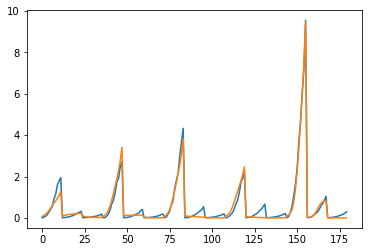

0.0979721480800498*(T*c**(3*t) + t**(c + t))**(T*(t*(0.0342304309961608*t - 0.487550751897452) + 2.42190722796226)*(-2*T - c + 1.43824008546392*t*(1.02237702572746*T)**(11.2071243404854*T/c + t) + 2.79906219833141))


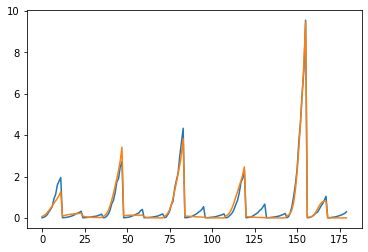

0.186795047364033*(T*c**(3*t) + t**(c + t))**(T*(T*(1.2846173654626 - 0.177711003121286*t) + 0.584844062991436)*(-2*T - c + 1.32259643995691*t*(1.05520609184951*T)**(14.3377857742417*T/c + t) + 2.6980349882992))


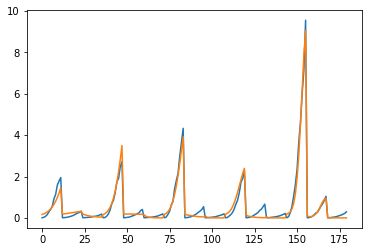

0.115718106202673*(T*c**(3*t) + t**(c + t))**(T*(t*(0.018743869961779*t - 0.298594028243893) + 1.77476299516543)*(-2*T - c + 2*(1.20592335385835*T)**(48.0918653312062*T*c**c + t) + 2.86054844975855))


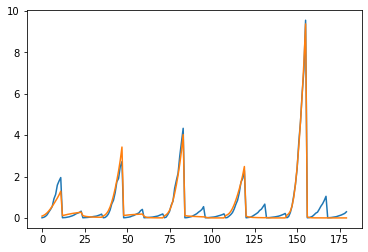

0.115718801652131*(T*c**(3*t) + t**(c + t))**(T*(t*(0.0187436302517122*t - 0.298590594373316) + 1.7747501914465)*(-2*T - c + 2*(1.20592154591864*T)**(48.0895511957822*T*c**2 + t) + 2.86054839776672))


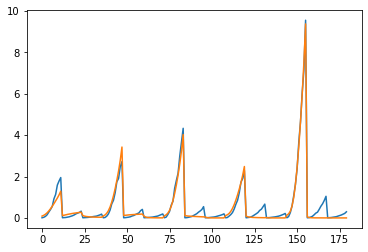

0.115717434246018*(T*c**(3*t) + t**(c + t))**(T*(t*(0.0187443050846374*t - 0.298600728530936) + 1.77478725510575)*(-2*T - c + 2*(1.20592919226928*T)**(48.099318942932*T*c**2 + t) + 2.86054933332295))


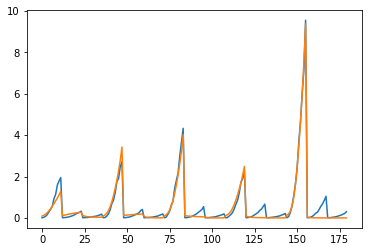

0.115717343438162*(T*c**(3*t) + t**(c + t))**(T*(t*(0.0187443515992378*t - 0.29860144568924) + 1.77478988797213)*(-2*T - c + 2*(1.20592979306784*T)**(48.1000843318231*T*c**2 + t) + 2.86054941810288))


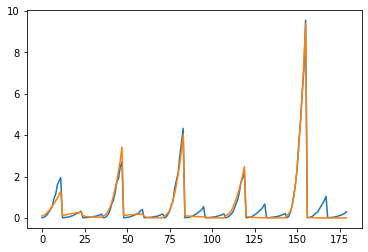

0.115719516066358*(T*c**(3*t) + t**(c + t))**(T*(t*(0.0187433271451191*t - 0.298585932407349) + 1.77473274491794)*(-2*T - c + 2*(1.20591793678088*T)**(48.0849318002785*T*c**2 + t) + 2.86054800561869))


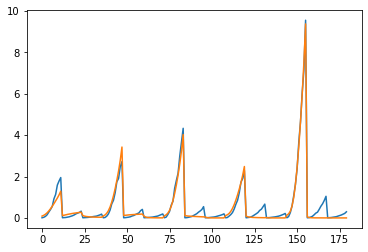

0.311805319733704*(T*c**(t*(t*(T**2 + 2*c + 2*t) - 103.801182470284)) + t**(c + t))**(0.260774685577773*T*t*(-T - c + (0.999138433849166*T)**(-0.539606034810329*T*c**2 + t) + 1.7306960593866))


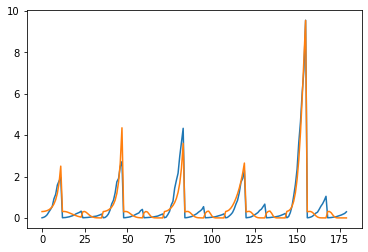

0.0601598901958595*(T*t + t**(c + t))**(0.126373058535478*(t*(0.0535752873794138*t - 0.845160797828615) + 4.56233100744202)*(-T - c + (1.25862285091098*T)**(T + t) + 2.99696837124454))


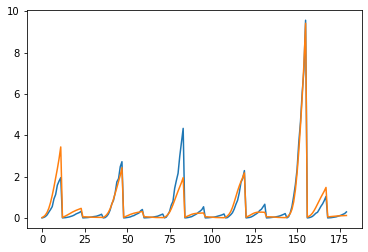

In [26]:
# For msd vs Temperature
for i in range(10):
  expr = Forest1.currentGeneration[i].expression
  print(expr)
  testF = lambdify([[t,c,T]], expr, 'numpy')
  result = testF(inputData)
  plt.plot(msdData)
  plt.plot(result)

  plt.savefig("plot_"+str(i)+".png",dpi=300)
  plt.show()

In [ ]:
with open('equations.log','w') as f:
  f.write("Final Generation: \n")
  for j in range(len(Forest1.currentGeneration)):
    f.write("%s %s %s %f\n\n" % ("Expression is: ", Forest1.currentGeneration[j].expression,
          "loss is ", Forest1.currentGeneration[j].loss))